In [1]:
# 命名したclusterでプロット後、各サンプルごとに各クラスターを集計する関数
# data=seurat.object(clusterプロット直後)
# types=cluster名(重複可)
cluster_count_function <- function(data,types){ 
    samplename <- c(unique(data[[]]$orig.ident))
    types2 <- unique(types)
    
    data <- AddMetaData(
    object=data,
    metadata=Idents(data),
    col.name='cell_type')
    
    # 入れ物用意
    values <- rep(0,length(samplename))
    names(values) <- samplename
    values <- t(as.data.frame(values))
    
    # countする
    for(i in 1:length(types2)){
    cr <- c()
        for(j in 1:length(samplename)){
            cr <- c(cr,dim(data[[]] %>% filter(cell_type==types2[i])%>% filter(orig.ident==samplename[j])
                %>%select(orig.ident))[1])
        }
    values <- rbind(values,cr)
    }
    rownames(values) <- c('emp',types2)
    cluster_count <- values[-1,]
    return(cluster_count)
    }

In [2]:
getwd()

[1] "/home/tsubosaka/stomach_normal_marker"

In [3]:
library(Seurat)
library(Matrix)
library(ggplot2)
library(cowplot)
library(dplyr)
library(enrichR)

Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3

********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Welcome to enrichR
Checking connection ... Connection is Live!


In [4]:
library(schex)

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following object is masked from ‘package:Matrix’:

    which

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, M

In [5]:
all <- readRDS('seurat_object/N-stomach-all.rds')

In [6]:
reticulate::import(module='umap')

Module(umap)

In [7]:
UMAP <- function(data.integrated, dims=1:30){
    data.integrated <- RunPCA(data.integrated, verbose = FALSE)
    data.integrated <- RunUMAP(data.integrated, dims = 1:30, verbose = FALSE, umap.method = 'umap-learn', metric = 'correlation')
    data.integrated <- FindNeighbors(data.integrated, dims = 1:30, verbose = FALSE)
    data.integrated <- FindClusters(data.integrated, verbose = FALSE)
    return (data.integrated)
}

In [8]:
macrophages <- readRDS('seurat_object/N-stomach-macrophages.rds')

In [9]:
UMAP3 <- function(data.integrated, dims=1:30){
    data.integrated <- RunPCA(data.integrated, verbose = FALSE)
    data.integrated <- RunUMAP(data.integrated, dims = 1:30, n.neighbors = 20, min.dist= 0.1, verbose = FALSE, umap.method = 'umap-learn', metric = 'correlation')
    data.integrated <- FindNeighbors(data.integrated, dims = 1:30, verbose = FALSE)
    data.integrated <- FindClusters(data.integrated, verbose = FALSE)
    return (data.integrated)
}

In [10]:
macrophages <- UMAP3(macrophages)

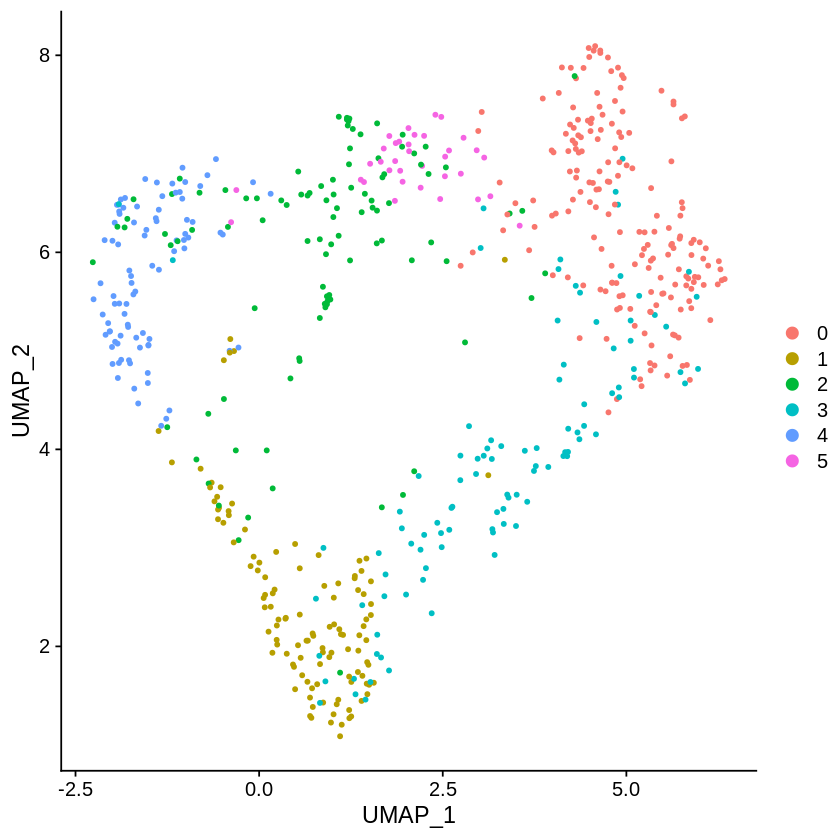

In [11]:
DimPlot(macrophages)

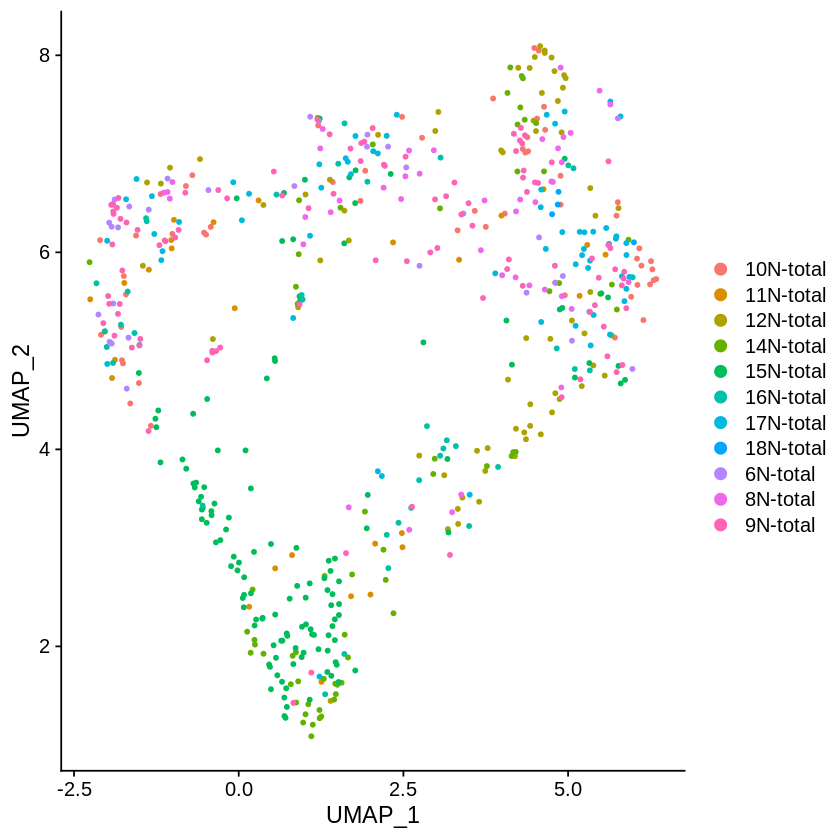

In [12]:
DimPlot(macrophages,group.by='orig.ident')

In [13]:
macro.marker <- FindAllMarkers(macrophages, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3
Calculating cluster 4
Calculating cluster 5


In [14]:
remove_samples <- function(data, sample_name){
    Idents(data) <- 'orig.ident'
    data <- subset(data, idents=sample_name,invert=TRUE)
    Idents(data) <- 'seurat_clusters'
    return (data)
}

In [15]:
all <- remove_samples(all,'18N-total')
macrophages <- remove_samples(macrophages,'18N-total')

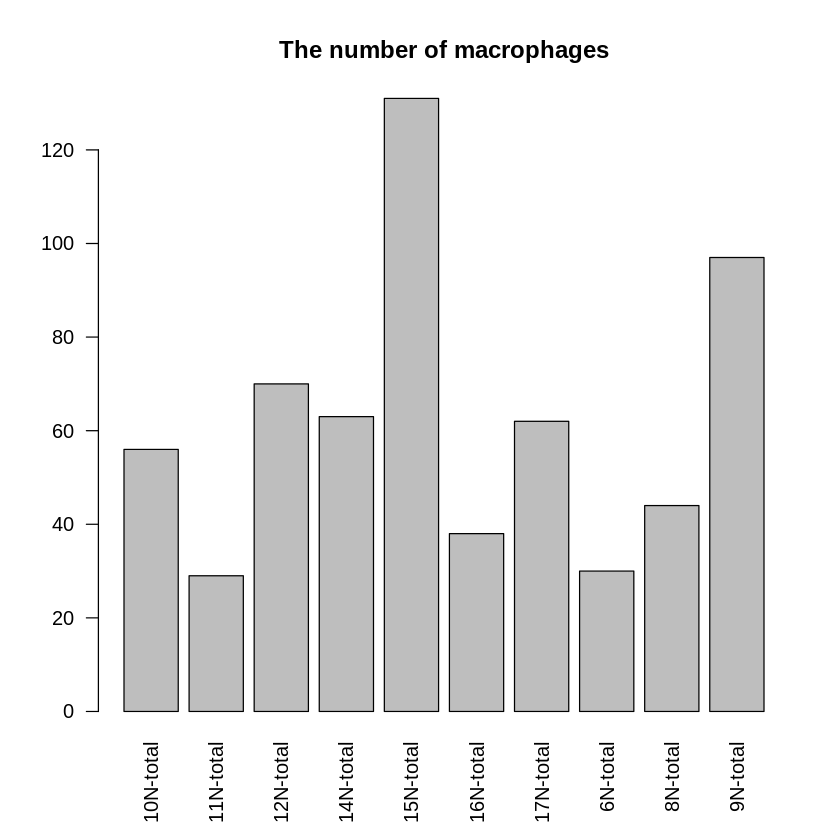

In [16]:
barplot(table(macrophages[[]]$orig.ident),las=2,xlab = ' ',main = 'The number of macrophages')

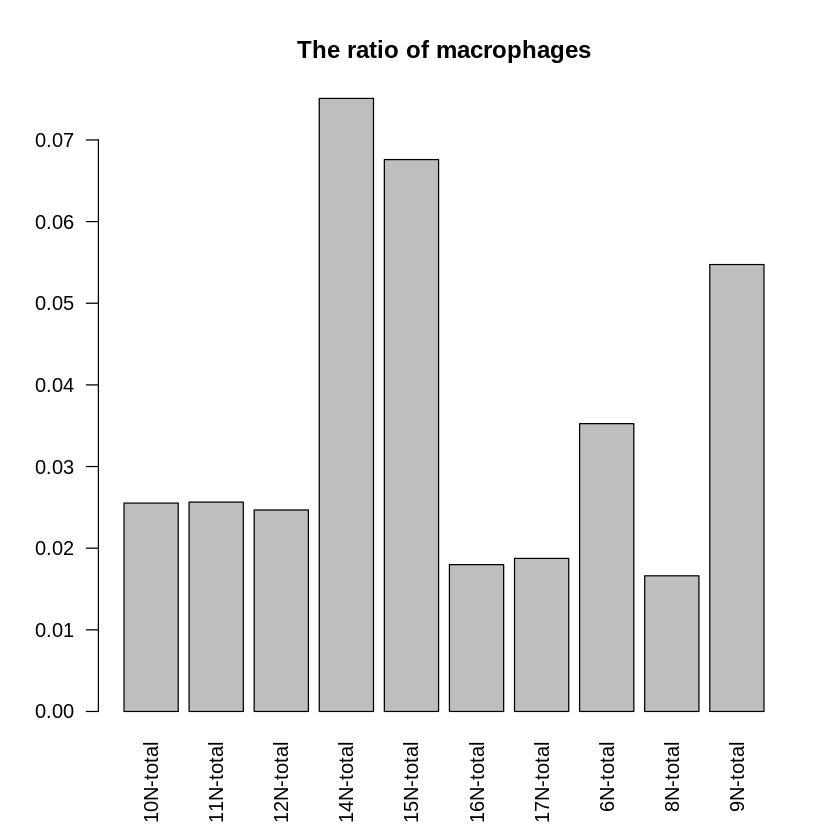

In [17]:
barplot(table(macrophages[[]]$orig.ident)/table(all[[]]$orig.ident),las=2,xlab = ' ',main = 'The ratio of macrophages')

# write.csv(macro.marker,file='seurat_object/macro_markers.csv')

In [18]:
macro.marker %>% head

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
SELENOP,3.477717e-78,2.030621,0.929,0.127,1.166357e-73,0,SELENOP
STAB1,1.881304e-68,2.024338,0.776,0.082,6.309518e-64,0,STAB1
C1QA,3.005173e-61,1.567183,0.967,0.299,1.007875e-56,0,C1QA
C1QC,3.611911e-53,1.467406,0.836,0.175,1.211363e-48,0,C1QC
SLCO2B1,1.021271e-51,1.549288,0.612,0.052,3.425138e-47,0,SLCO2B1
C1QB,5.353347e-48,1.303545,0.923,0.331,1.795406e-43,0,C1QB


In [19]:
for(i in 0:5){
    print(macro.marker %>% filter(cluster==i) %>%filter(p_val_adj<0.05))
    print(' ')
    print(' ')
    print(' ')
}

           p_val avg_logFC pct.1 pct.2    p_val_adj cluster      gene
1   3.477717e-78 2.0306213 0.929 0.127 1.166357e-73       0   SELENOP
2   1.881304e-68 2.0243381 0.776 0.082 6.309518e-64       0     STAB1
3   3.005173e-61 1.5671833 0.967 0.299 1.007875e-56       0      C1QA
4   3.611911e-53 1.4674060 0.836 0.175 1.211363e-48       0      C1QC
5   1.021271e-51 1.5492880 0.612 0.052 3.425138e-47       0   SLCO2B1
6   5.353347e-48 1.3035450 0.923 0.331 1.795406e-43       0      C1QB
7   6.089330e-45 1.7613955 0.710 0.143 2.042239e-40       0   SLC40A1
8   1.083684e-43 1.4369755 0.563 0.057 3.634460e-39       0       MAF
9   1.220743e-42 1.3097715 0.699 0.127 4.094128e-38       0      DAB2
10  6.482067e-40 1.2309635 0.628 0.107 2.173956e-35       0       CD4
11  2.363790e-38 1.3234410 0.464 0.036 7.927677e-34       0  ADAMDEC1
12  3.643556e-38 1.5931244 0.432 0.027 1.221976e-33       0     CD209
13  1.017613e-37 1.4840137 0.383 0.011 3.412869e-33       0    LILRB5
14  9.096223e-36 1.1

In [20]:
M1vsM2 <- c('CCR7', # Membrane receptors
            'IL2RA',
            'IL15RA',
            'IL7R',
            'TGFBR2',
            'HRH1',
            'TLR5',
            'MSR1',
            'CXCR4',
            'CLEC7A',
            'P2RY14',
            'CLEC4M',
            'CLECSF13',
            'MS4A6A',
            'CD36',
            'MS4A4A',
            'MRC1',
            'CXCL11', # Cytokines and chemokines
            'CCL19',
            'CXCL10',
            'CXCL9',
            'TNF',
            'CCL5',
            'CCL15',
            'IL12B',
            'IL15',
            'TRAIL',
            'IL6',
            'CCL20',
            'PBEF1',
            'ECGF1',
            'IGF1',
            'CCL23',
            'CCL18',
            'CCL13',
            'BCL2A1', # Apoptosis-related genes
            'FAS',
            'BIRC3',
            'GADD45G',
            'HSXIAPAF1',
            'SLC7A5', # solute carriers
            'SLC21A15',
            'SCL2A6',
            'SLC31A2',
            'SLC21A9',
            'SLC4A7',
            'SLC38A6',
            'INDO', # enzymes
            'PLA1A',
            'OASL',
            'CHI3L2',
            'HSD11B1',
            'AK3',
            'SPHK1',
            'PFKFB3',
            'PSME2',
            'PFKP',
            'PSMB9',
            'PSMA2',
            'OAS2',
            'CTSC',
            'HEXB',
            'LIPA',
            'ADK',
            'HNMT',
            'TPST2',
            'CERK',
            'HS3ST2',
            'LTA4H',
            'CA2',
            'ALOX15',
            'HS3ST1',
            'PTX3', # Extracellular mediators
            'CSPG2',
            'APOL3',
            'IGFBP4',
            'APOL1',
            'PDGFA',
            'END1',
            'APOL2',
            'INHBA',
            'APOL6',
            'TGFB1',
            'SEPP1',
            'CHN2',
            'FN1',
            'FGL2',
            'HESX1', # DNA-binding facotrs
            'IRF1',
            'ATF3',
            'IRF7',
            'GAS7',
            'EGR2',
            'MAF'
            )

In [ ]:
options(repr.plot.width=7, repr.plot.height=7*length(M1vsM2))
FeaturePlot(macrophages,features=M1vsM2)

Warning message in FetchData(object = object, vars = c(dims, "ident", features), :
“The following requested variables were not found (10 out of 12 shown): CLECSF13, TRAIL, PBEF1, ECGF1, HSXIAPAF1, SLC21A15, SCL2A6, SLC21A9, INDO, CSPG2”Warning message in FeaturePlot(macrophages, features = M1vsM2):
“All cells have the same value (0) of CLEC4M.”Warning message in FeaturePlot(macrophages, features = M1vsM2):
“All cells have the same value (0) of PLA1A.”Warning message in FeaturePlot(macrophages, features = M1vsM2):
“All cells have the same value (0) of ALOX15.”

### gene0 <- as.data.frame(macro.marker %>% filter(cluster==0) %>%filter(p_val_adj<0.05)%>%select(gene))

gene1 <- as.data.frame(macro.marker %>% filter(cluster==1) %>%filter(p_val_adj<0.05)%>%select(gene))

gene2 <- as.data.frame(macro.marker %>% filter(cluster==2) %>%filter(p_val_adj<0.05)%>%select(gene))
gene3 <- as.data.frame(macro.marker %>% filter(cluster==3) %>%filter(p_val_adj<0.05)%>%select(gene))
gene4 <- as.data.frame(macro.marker %>% filter(cluster==4) %>%filter(p_val_adj<0.05)%>%select(gene))
gene5 <- as.data.frame(macro.marker %>% filter(cluster==5) %>%filter(p_val_adj<0.05)%>%select(gene))

write.csv(gene0,'seurat_object/macrophage_cluster0_gene.csv')
write.csv(gene1,'seurat_object/macrophage_cluster1_gene.csv')
write.csv(gene2,'seurat_object/macrophage_cluster2_gene.csv')
write.csv(gene3,'seurat_object/macrophage_cluster3_gene.csv')
write.csv(gene4,'seurat_object/macrophage_cluster4_gene.csv')
write.csv(gene5,'seurat_object/macrophage_cluster5_gene.csv')

In [36]:
marker23 <- FindMarkers(macrophages, ident.1 =2 , ident.2=3, only.pos=TRUE)
marker32 <- FindMarkers(macrophages, ident.1 =3 , ident.2=2, only.pos=TRUE)

In [37]:
marker23 <- cbind(marker23, rownames(marker23))

marker23 %>% filter(p_val_adj<0.05)

p_val,avg_logFC,pct.1,pct.2,p_val_adj,rownames(marker23)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6.263261e-09,2.1410753,0.314,0.01,0.0002100572,LGALS2
2.917091e-08,0.8439417,0.833,0.64,0.0009783341,HLA-DPB1
1.371130e-07,0.7786042,0.912,0.75,0.0045984958,ACTB
1.082328e-06,1.0128277,0.412,0.10,0.0362991119,FGL2


In [38]:
marker32 <- cbind(marker32, rownames(marker32))

marker32 %>% filter(p_val_adj<0.05)

p_val,avg_logFC,pct.1,pct.2,p_val_adj,rownames(marker32)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1.418943e-21,2.739266,0.73,0.078,4.758852e-17,C1QA
7.930039e-20,2.544079,0.71,0.088,2.659576e-15,C1QB
1.604228e-18,1.170554,1.00,0.814,5.380260e-14,FTL
3.458119e-16,3.515047,0.56,0.039,1.159784e-11,APOC1
1.580406e-15,3.027087,0.57,0.059,5.300367e-11,APOE
5.250564e-10,2.501052,0.41,0.049,1.760934e-05,SELENOP
9.414229e-10,1.709242,0.40,0.039,3.157344e-05,C1QC
1.828476e-08,2.113953,0.37,0.049,6.132344e-04,SLC40A1
2.025127e-08,1.454763,0.49,0.118,6.791871e-04,CTSD


In [49]:
marker0 <- c('SELENOP',
            'STAB1',
            'C1QA',
            'C1QC',
            'SLCO2B1',
            'C1QB',
            'MAF',
            'CD209') # 8
marker1 <- c('SPP1',
            'APOC1',
            'GCHFR',
            'GPNMB',
            'CCL18',
            'GPNMB') # 6
marker2 <- c('LGALS2')
marker3 <- c('C1QB','C1QA')
marker4 <- c('S100A8','S100A12','S100A9','FCN1',
            'VCAN','NAMPT','SLC2A3','IL1B',
            'NFKBIZ')
marker5 <- c('CD1E','FCER1A','CLEC10A','FCGR2B','CX3CR1','LINC01116')

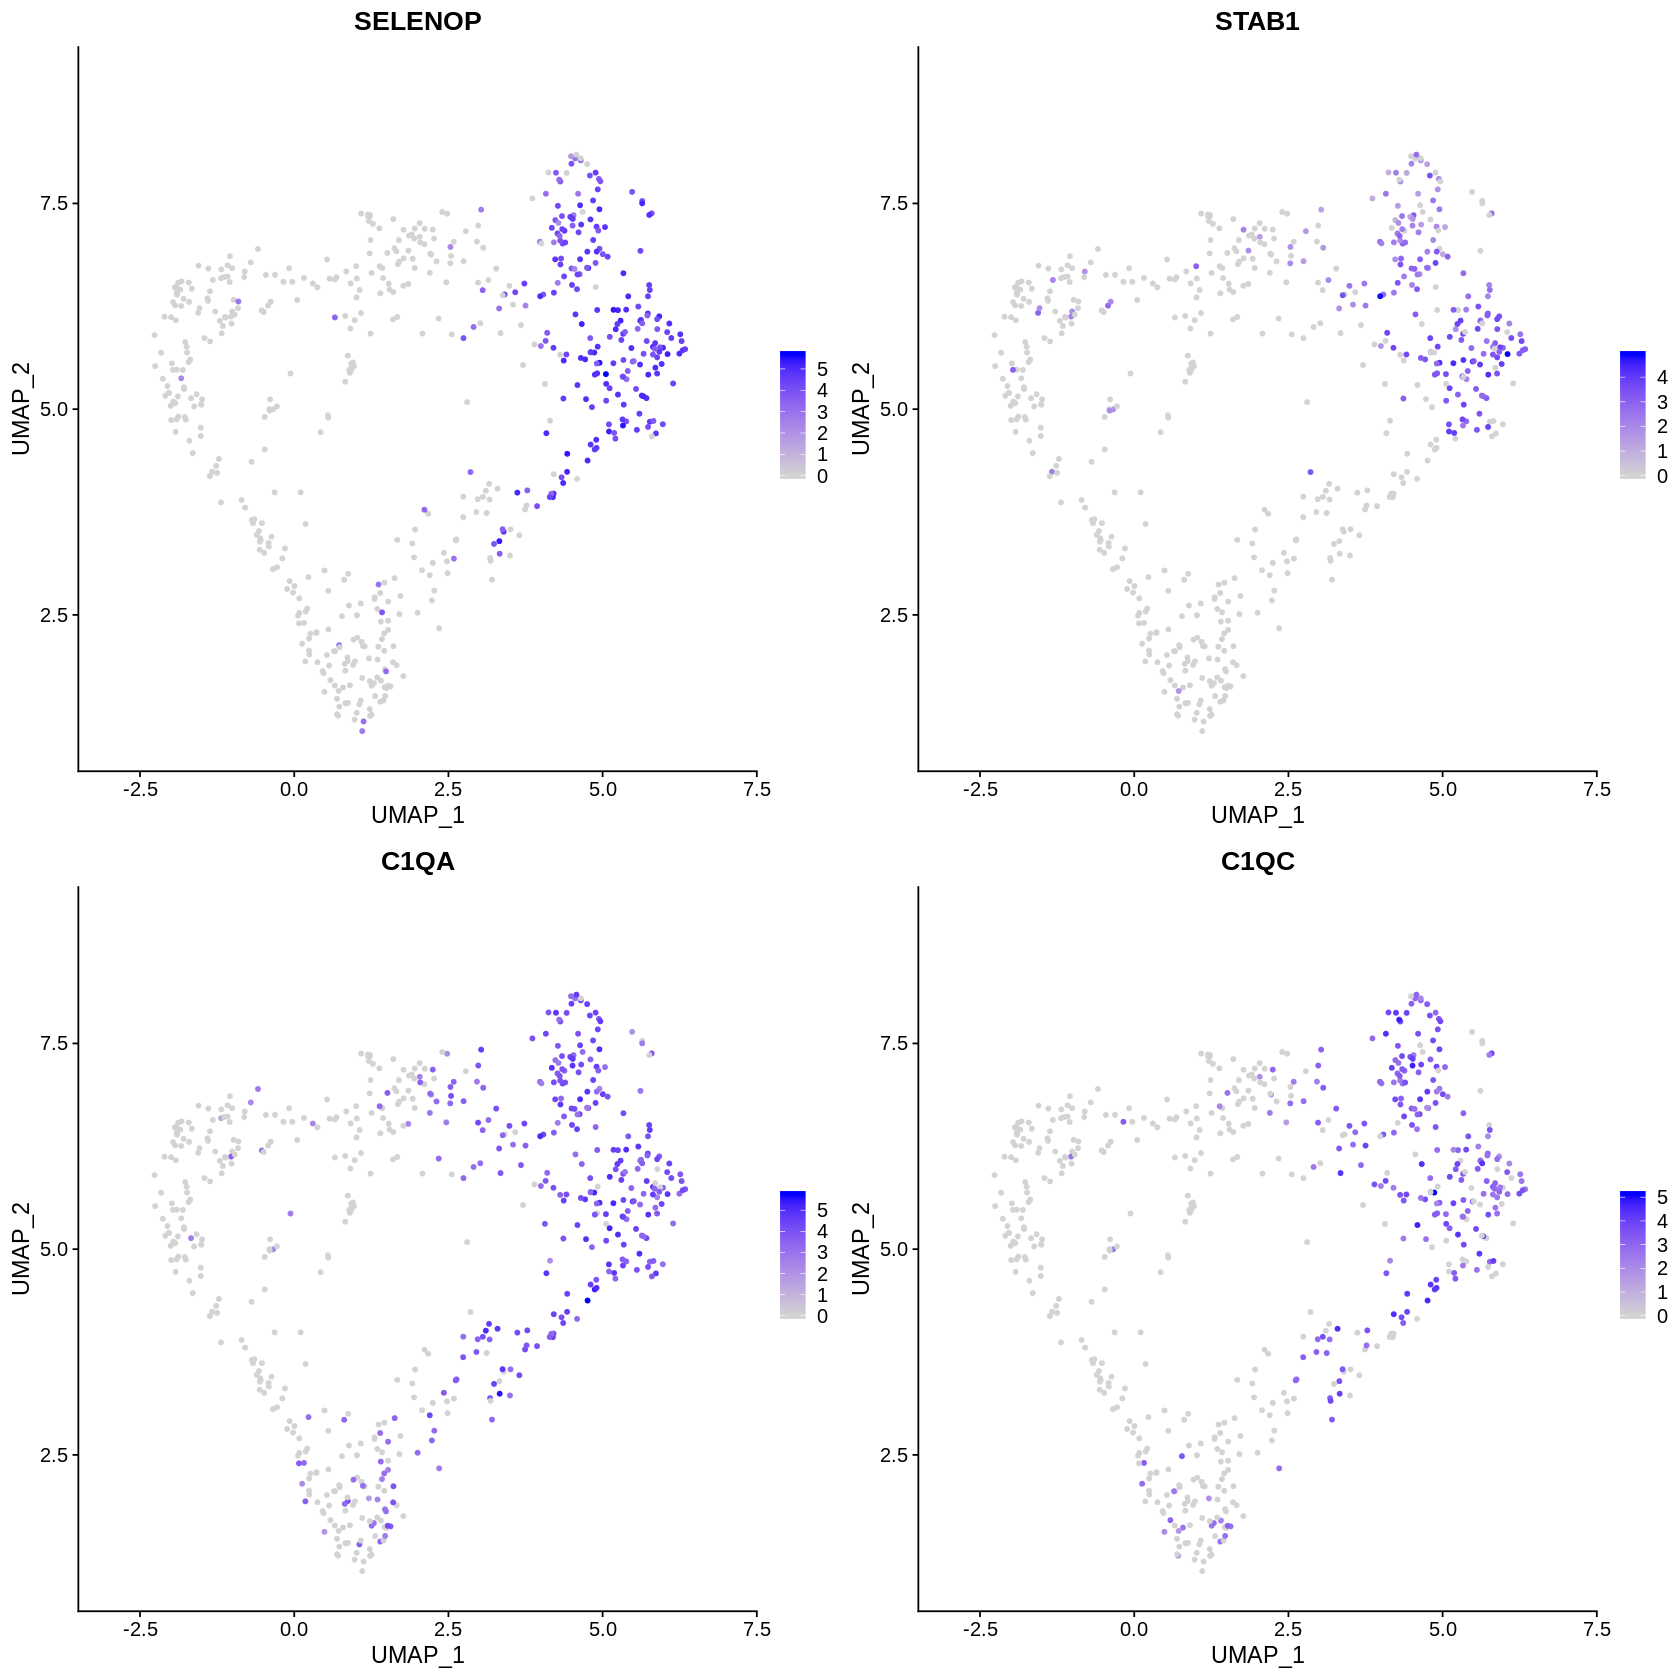

In [41]:
options(repr.plot.width=7*2, repr.plot.height=7*2)
FeaturePlot(macrophages,features=marker0[1:4],ncol=2)
options(repr.plot.width=7, repr.plot.height=7)

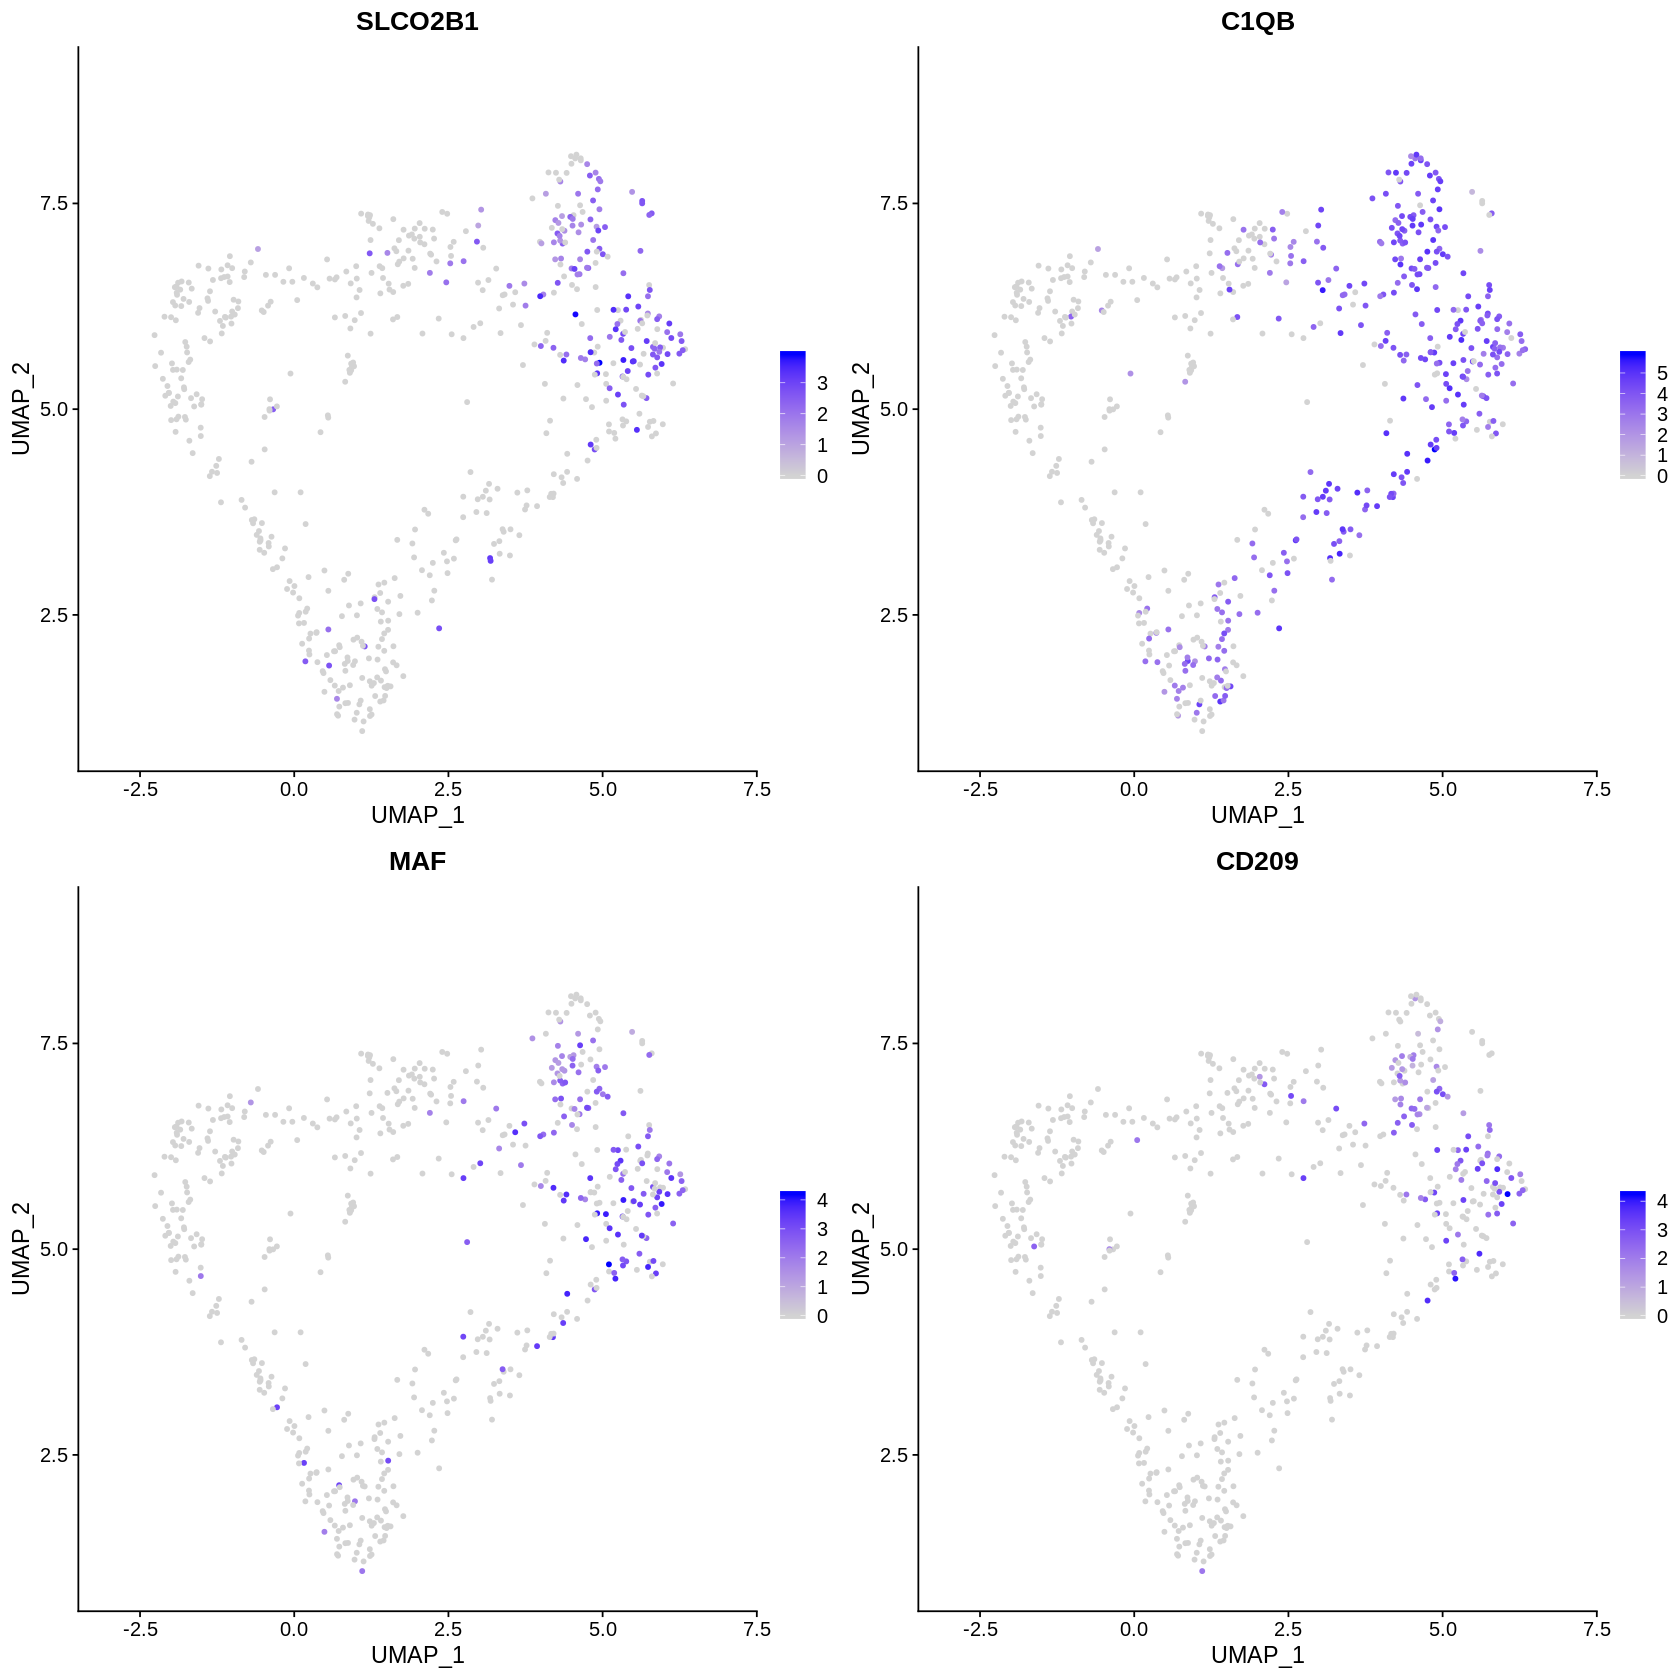

In [42]:
options(repr.plot.width=7*2, repr.plot.height=7*2)
FeaturePlot(macrophages,features=marker0[5:8],ncol=2)
options(repr.plot.width=7, repr.plot.height=7)

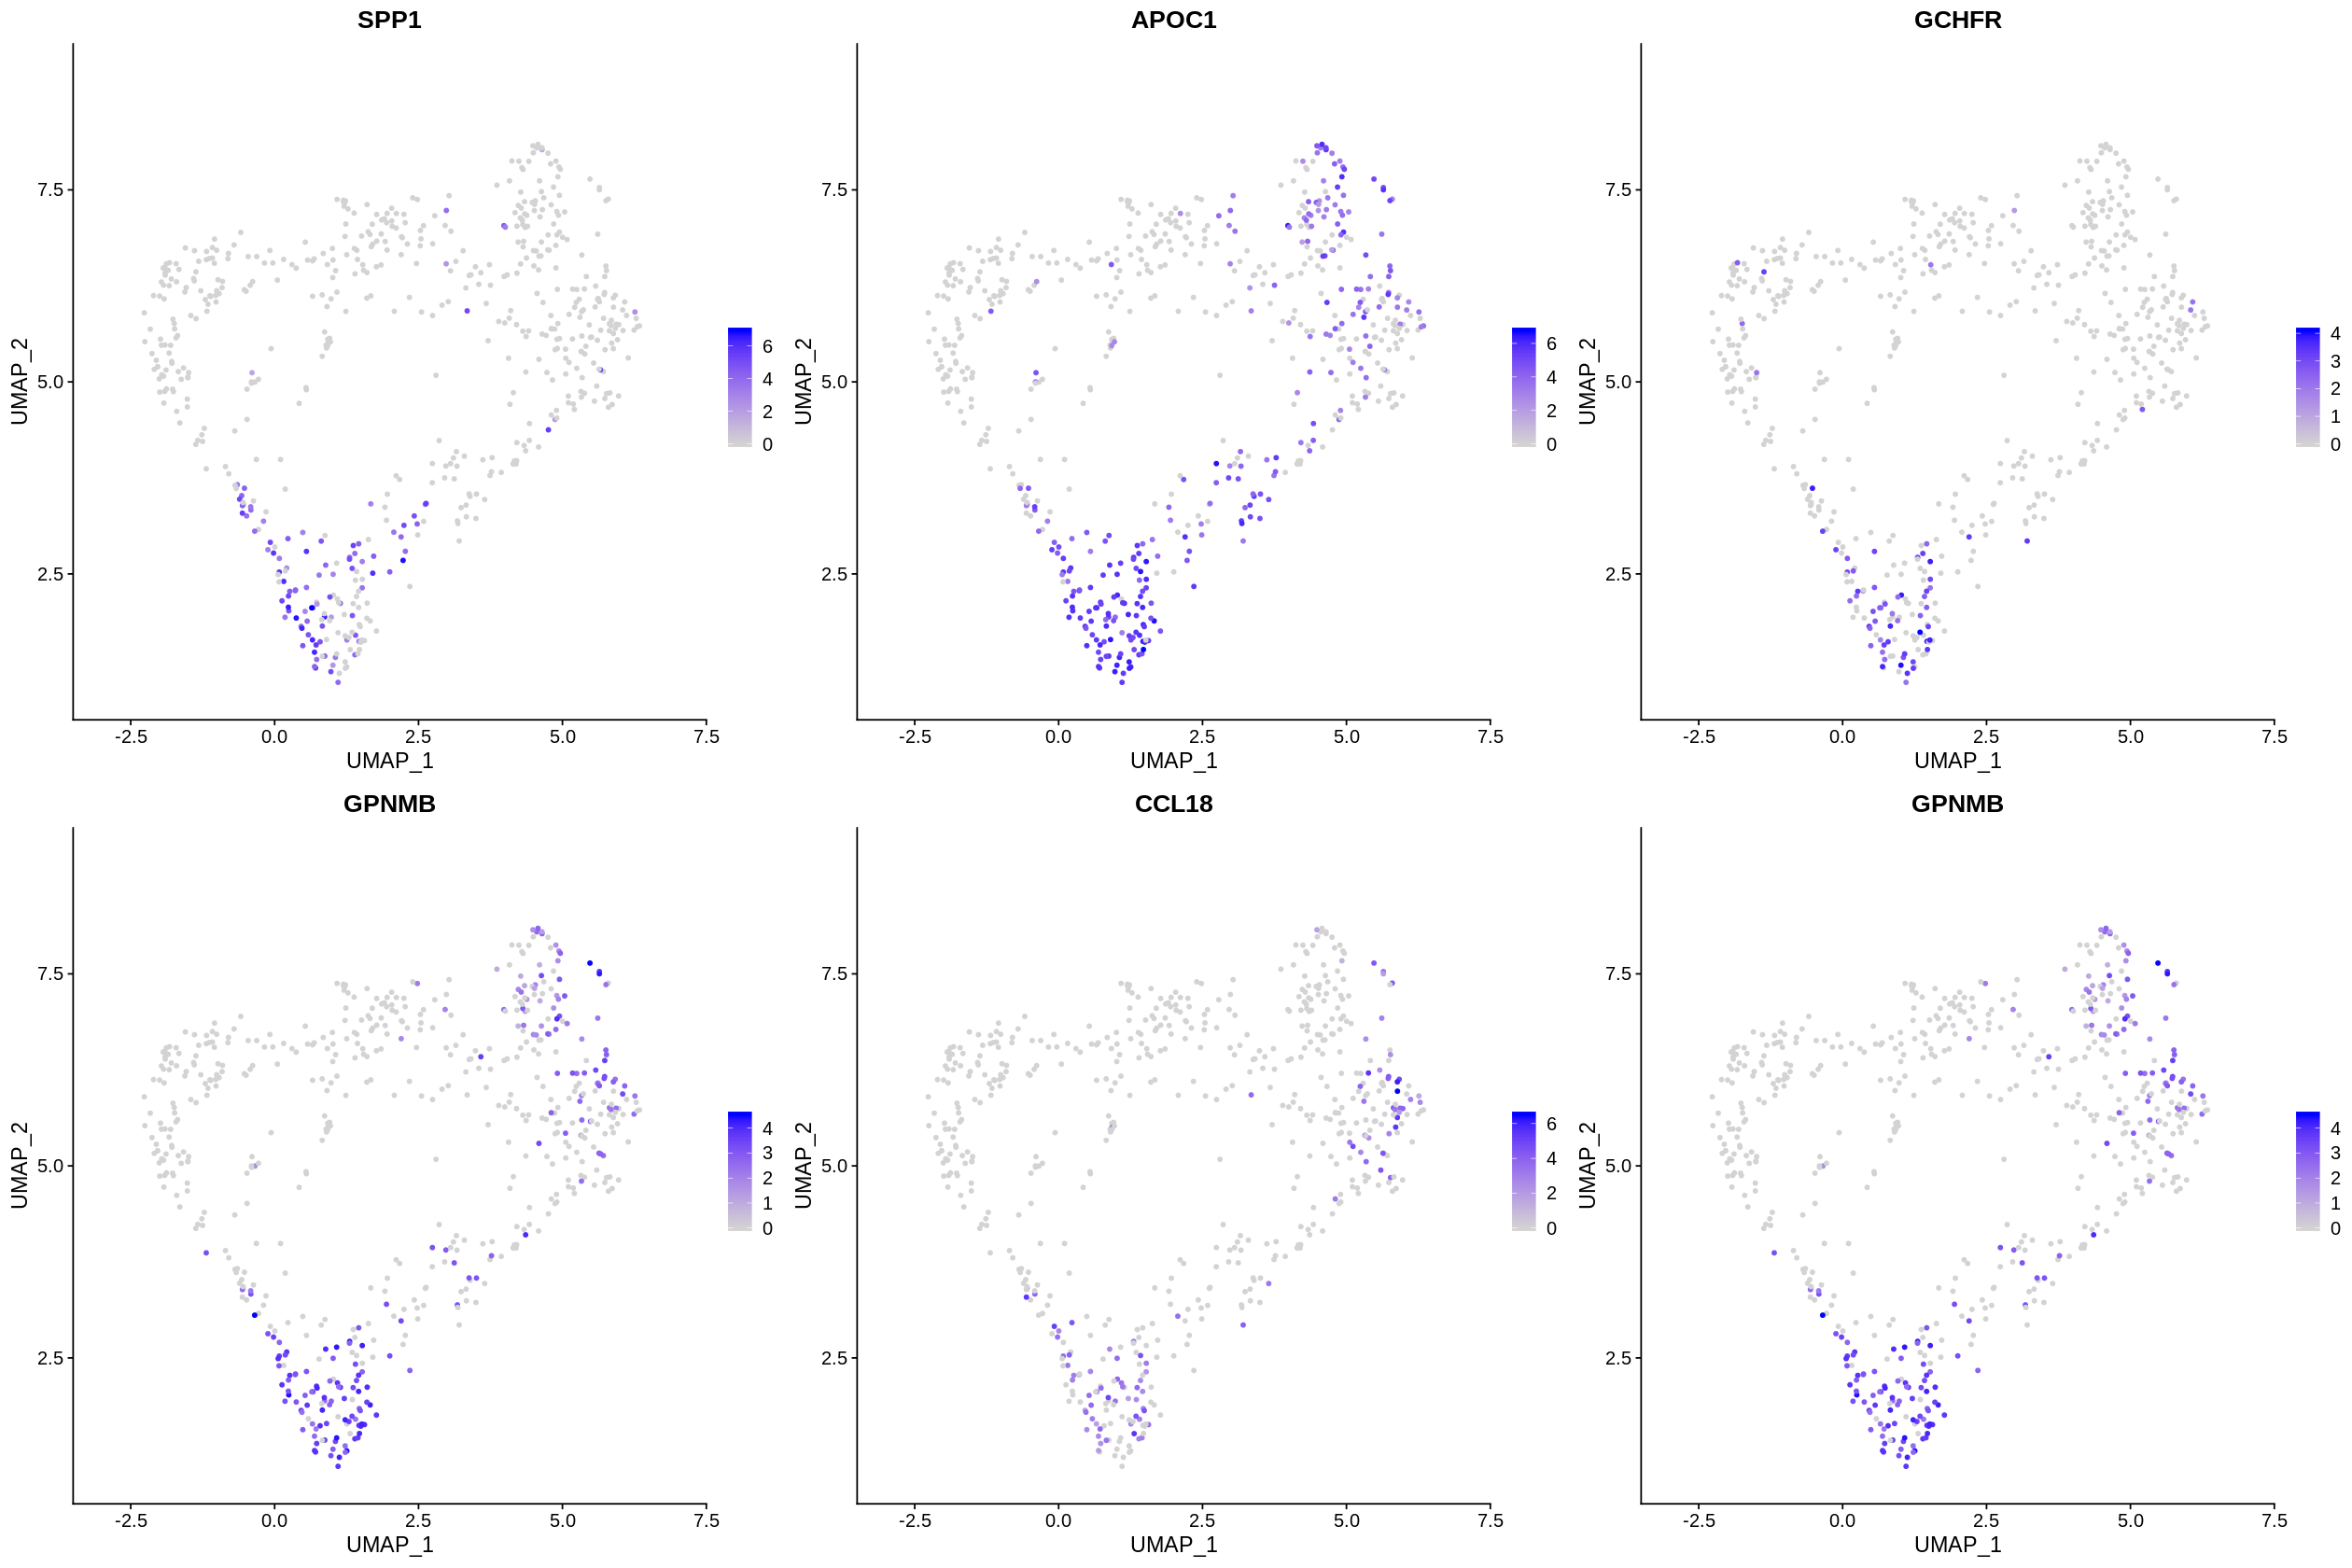

In [47]:
options(repr.plot.width=7*3, repr.plot.height=7*2)
FeaturePlot(macrophages,features=marker1,ncol=3)
options(repr.plot.width=7, repr.plot.height=7)

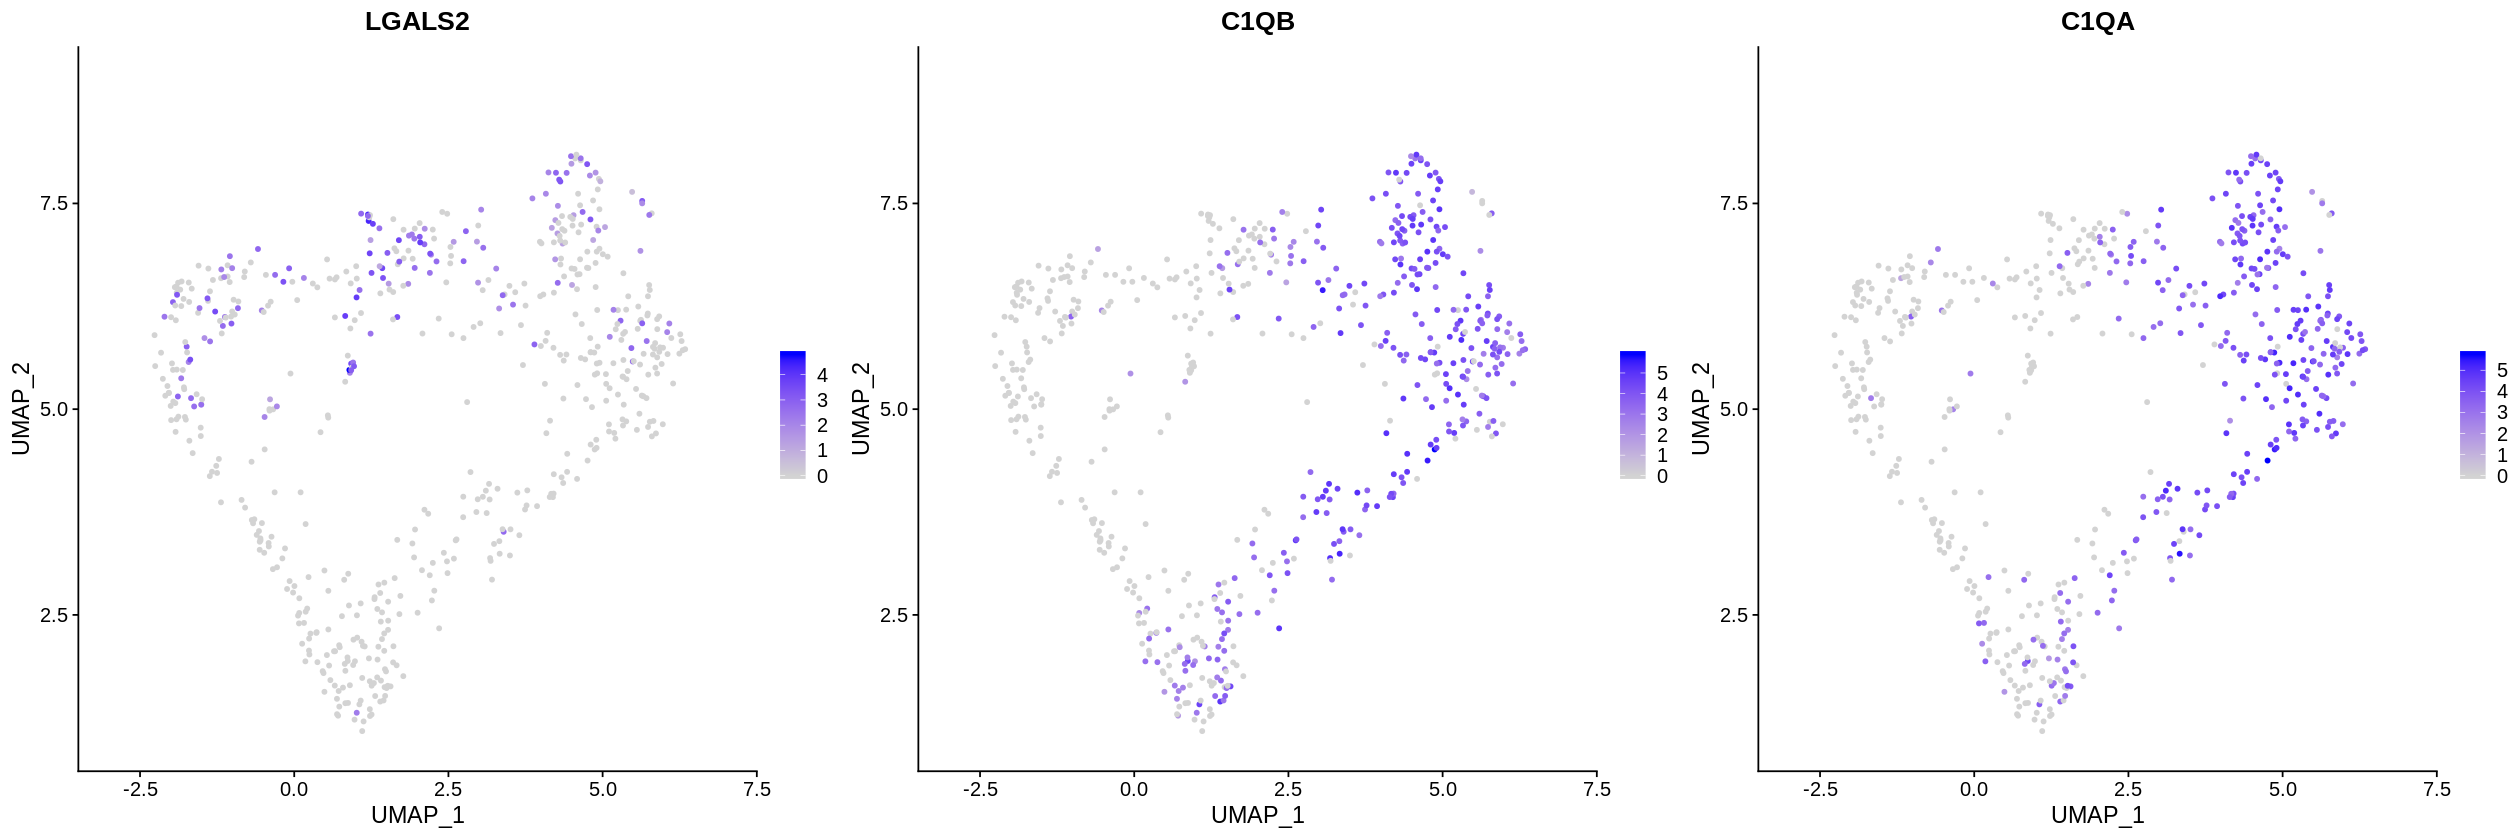

In [50]:
options(repr.plot.width=7*3, repr.plot.height=7*1)
FeaturePlot(macrophages,features=c(marker2,marker3),ncol=3)
options(repr.plot.width=7, repr.plot.height=7)

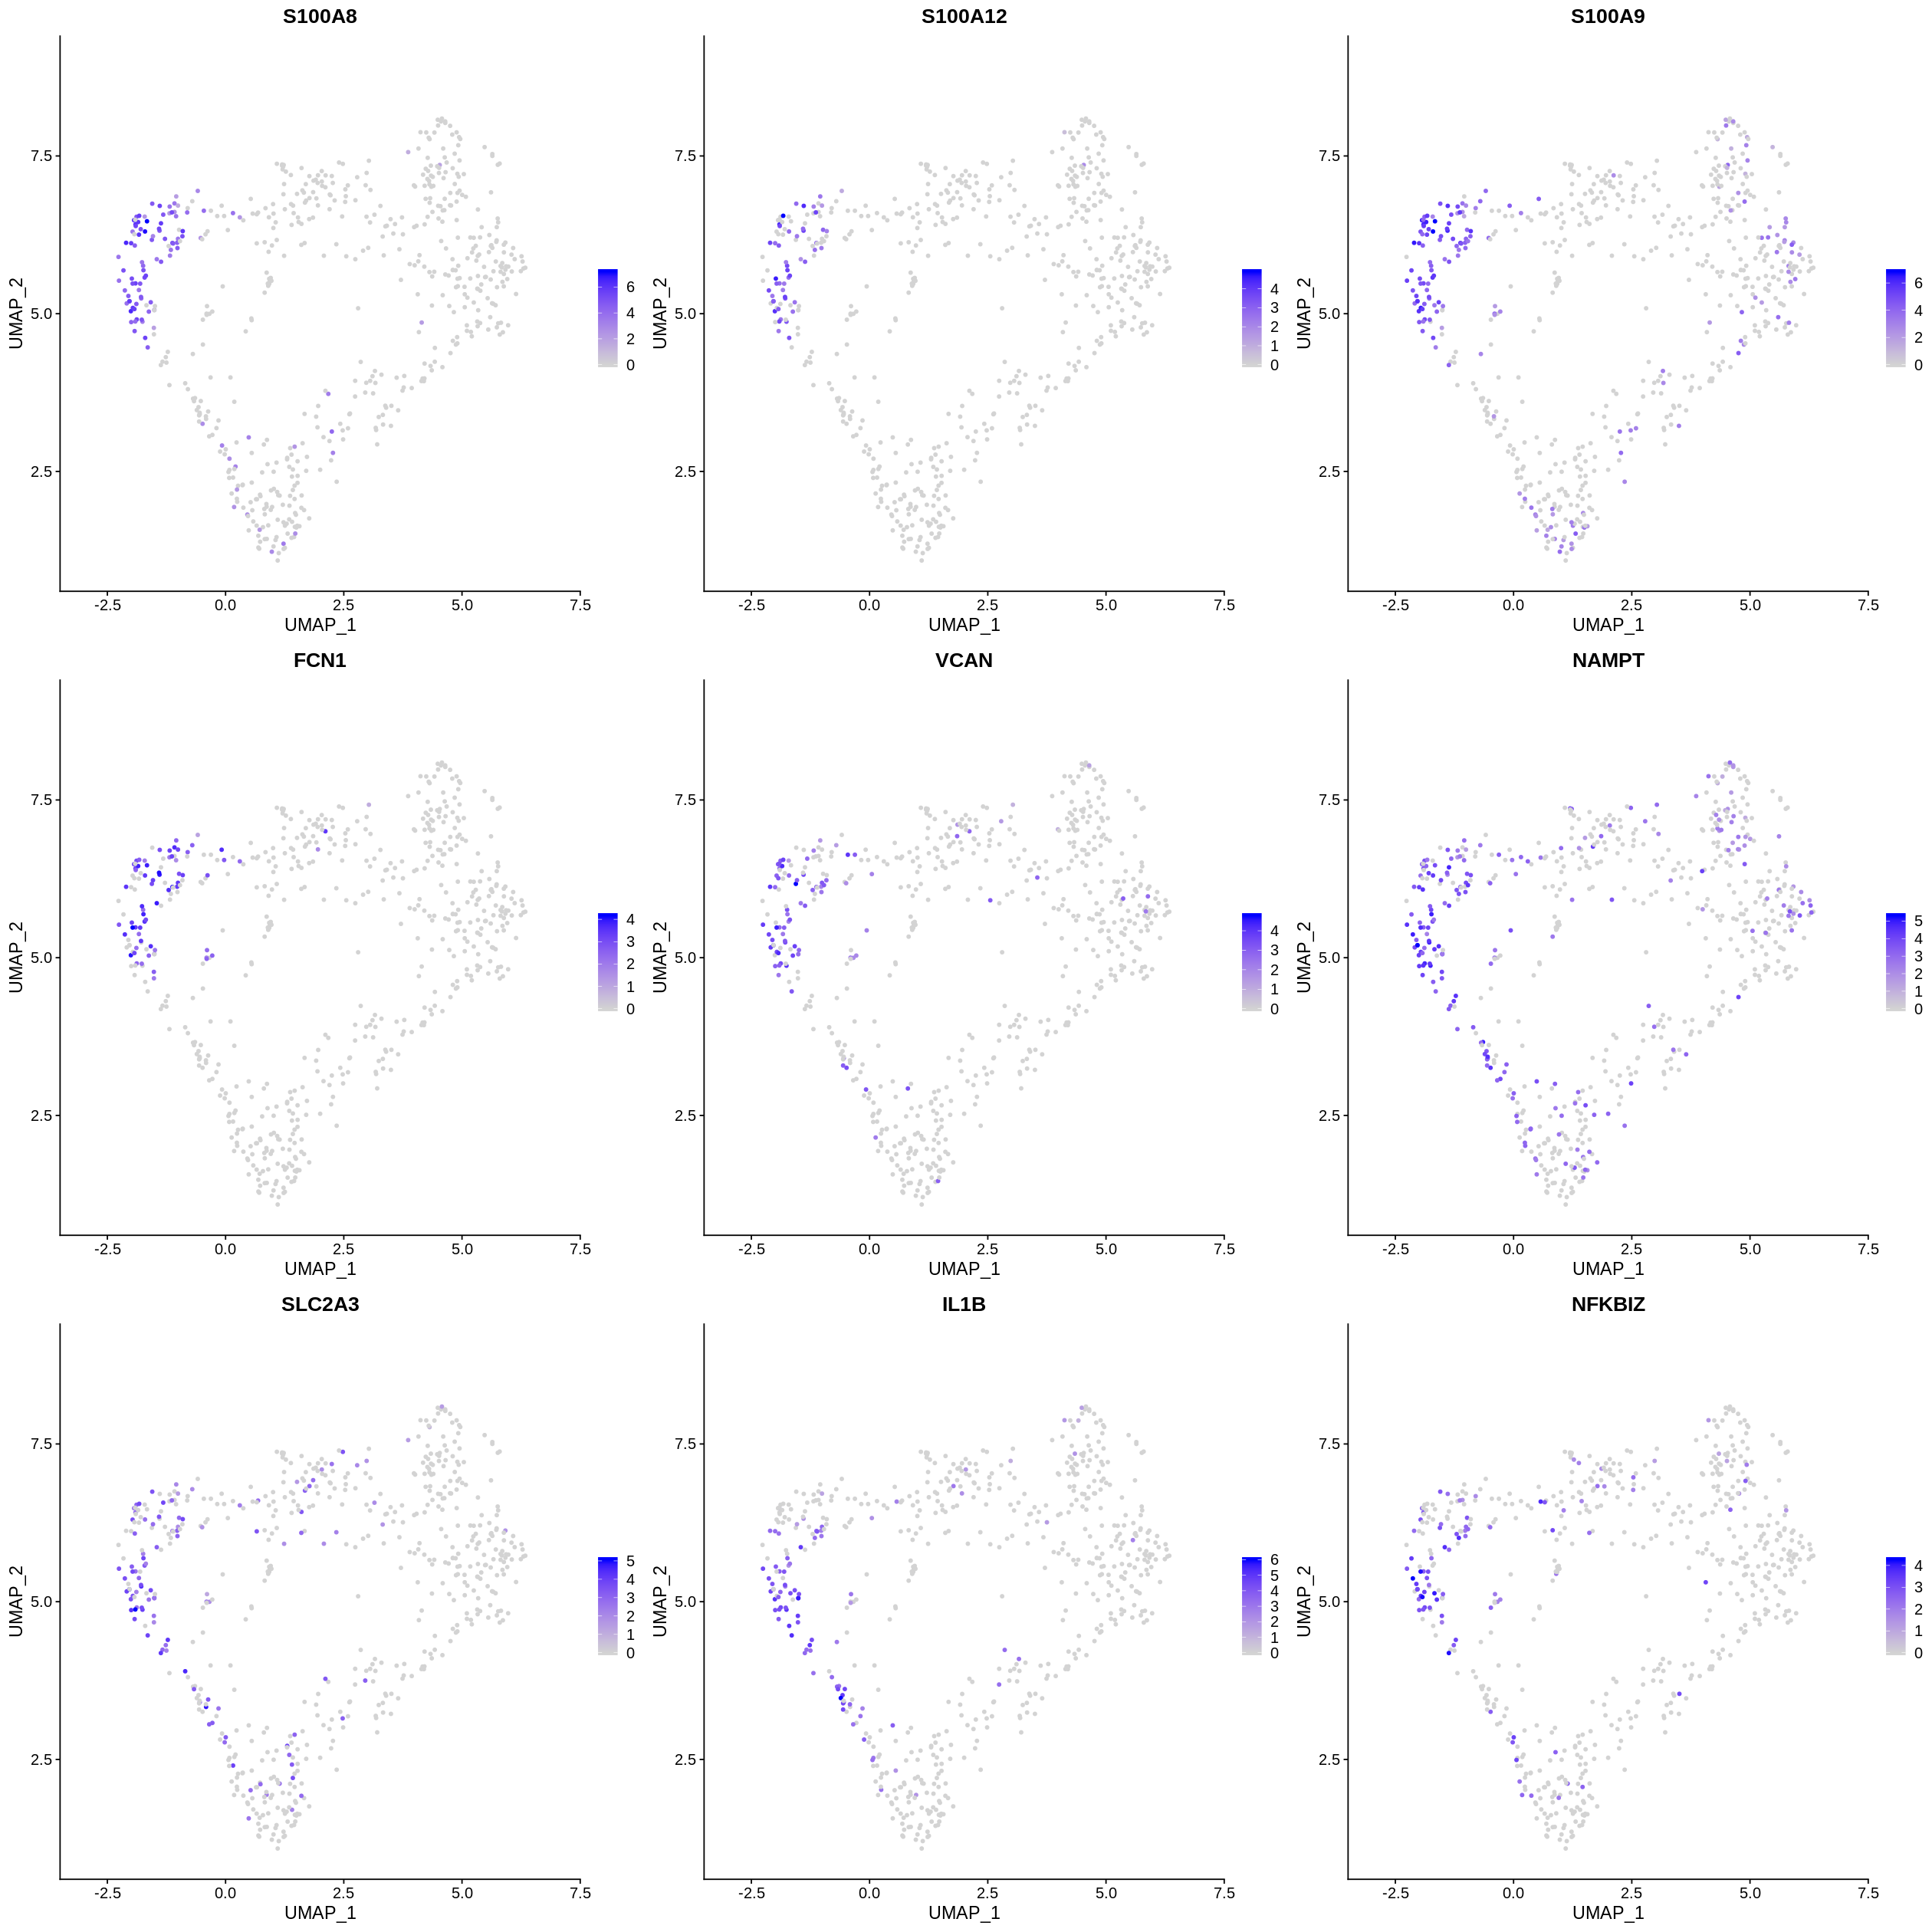

In [54]:
options(repr.plot.width=7*3, repr.plot.height=7*3)
FeaturePlot(macrophages,features=marker4,ncol=3)
options(repr.plot.width=7, repr.plot.height=7)

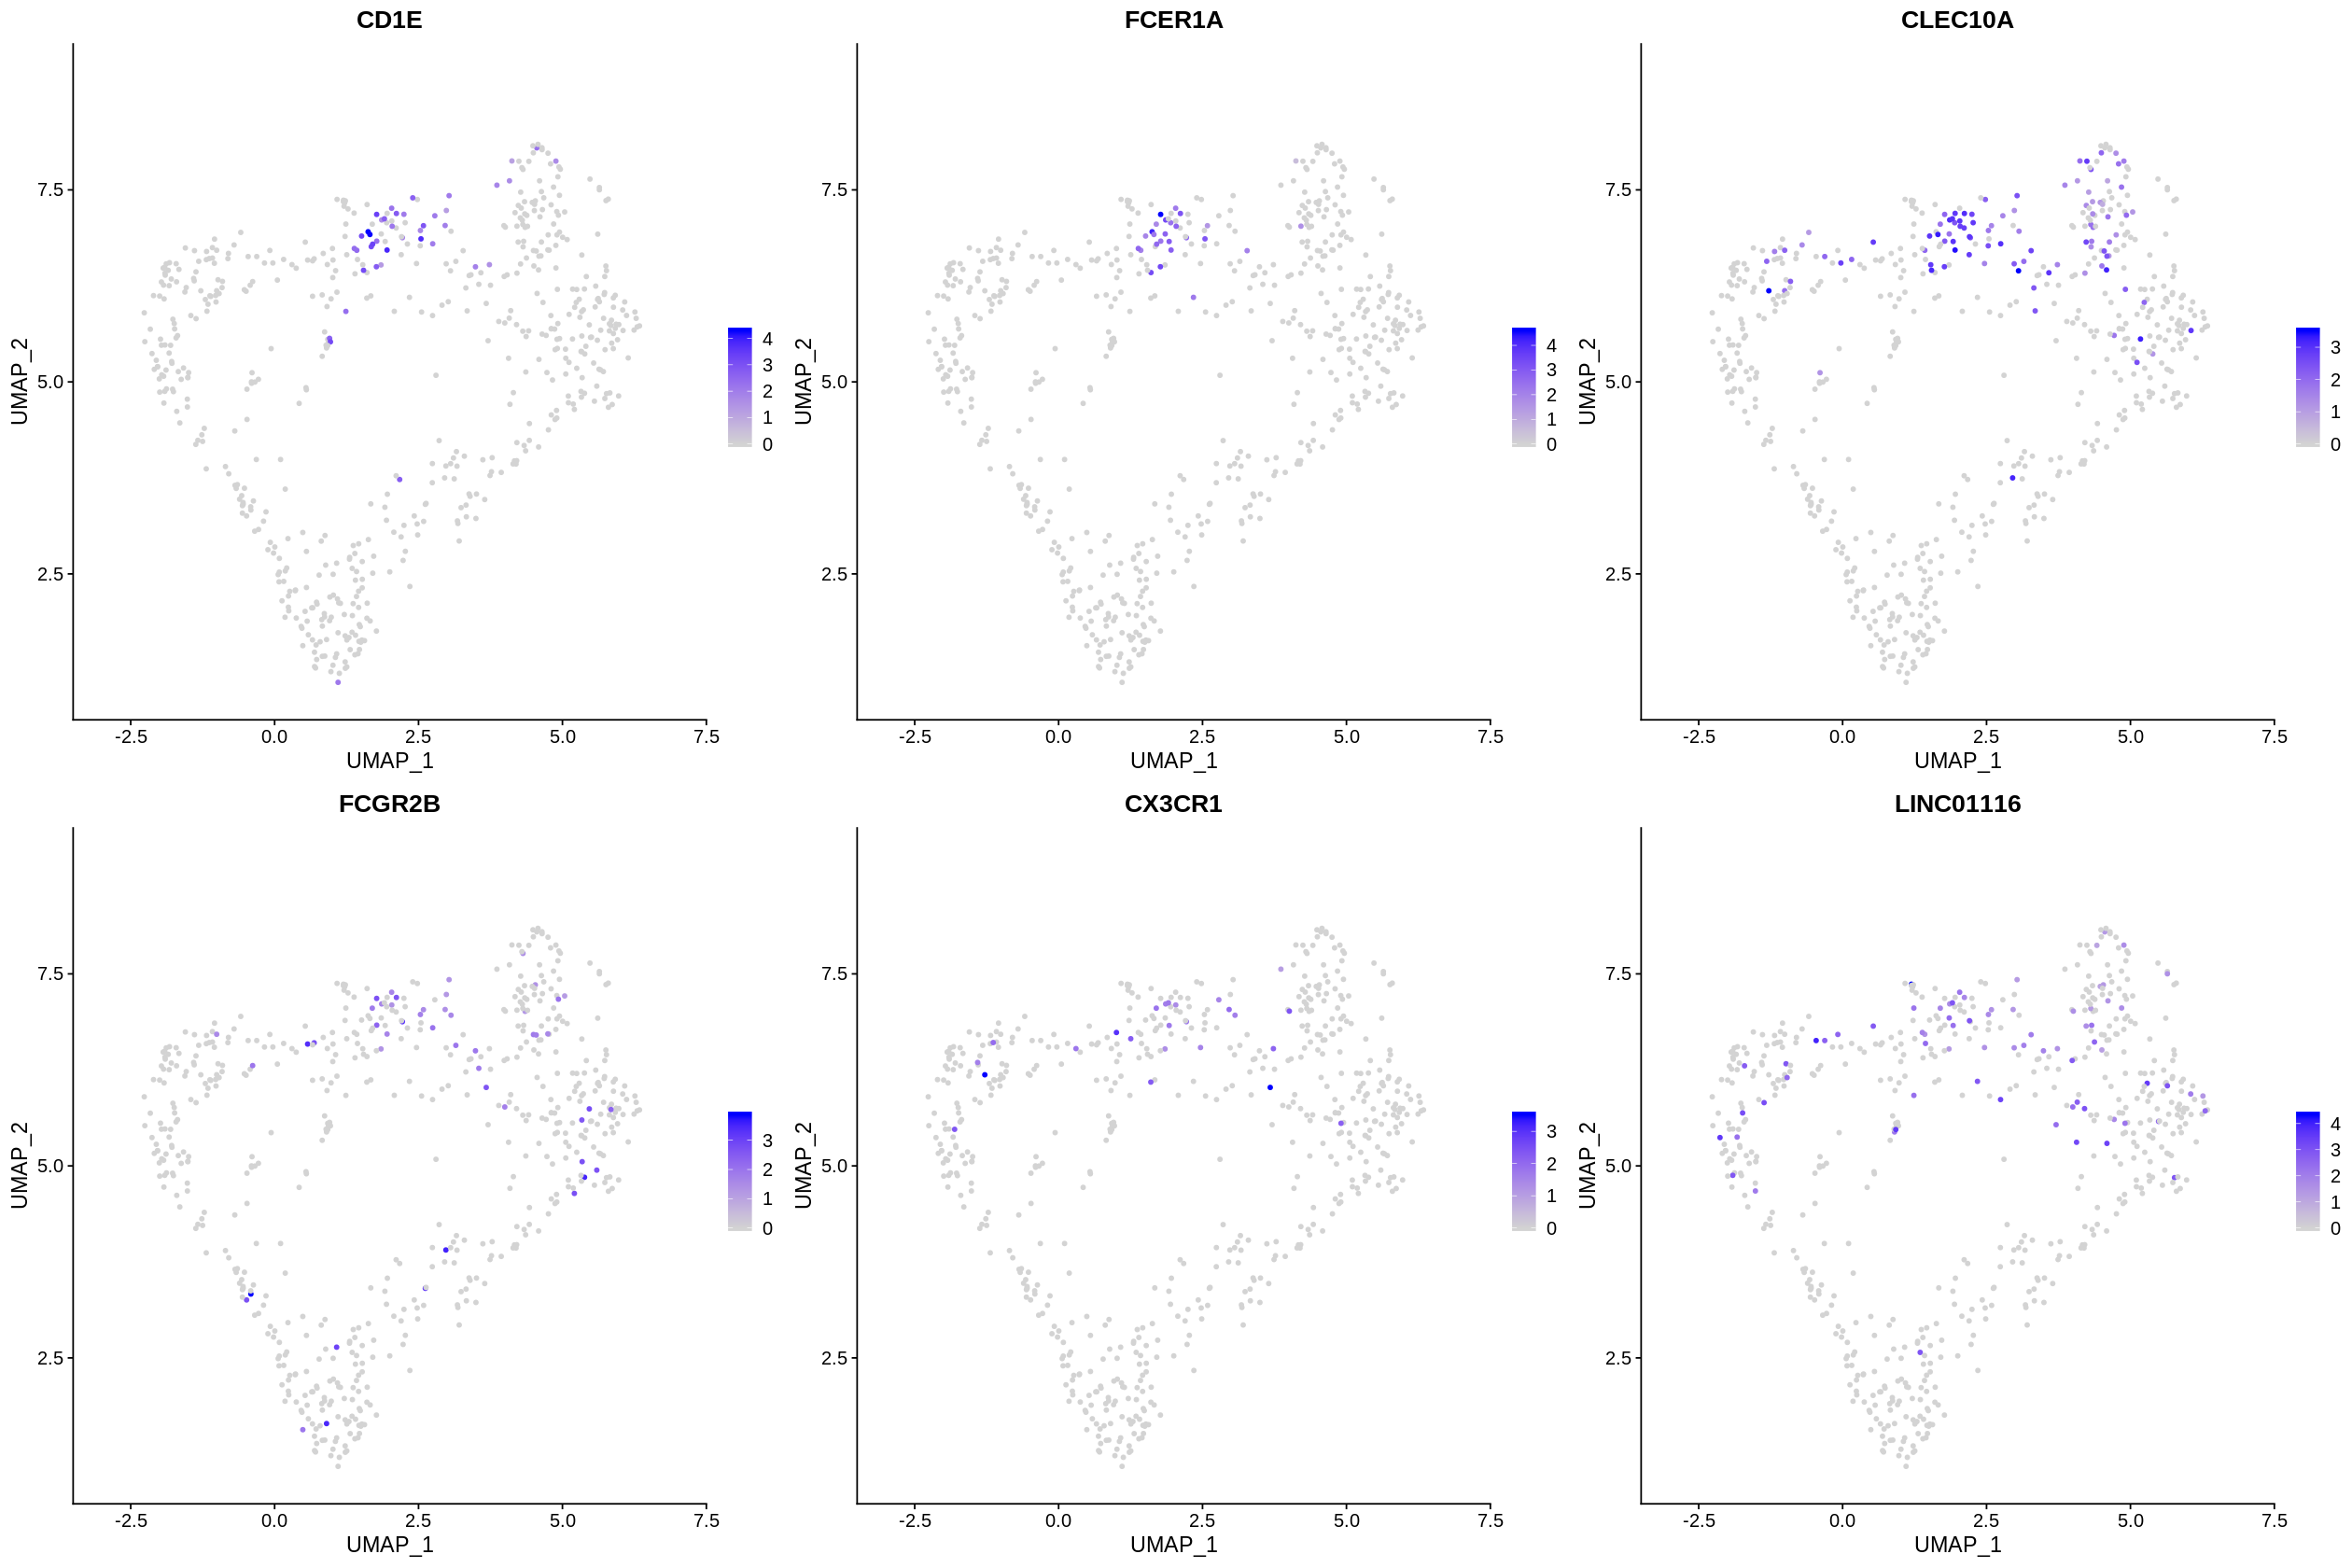

In [55]:
options(repr.plot.width=7*3, repr.plot.height=7*2)
FeaturePlot(macrophages,features=marker5,ncol=3)
options(repr.plot.width=7, repr.plot.height=7)

In [53]:
length(marker5)

[1] 6

In [56]:
types <- c('phagocytic','tissue-reparing','nonfunctinal?','innate-immunity(nonactivated)',
          'inflammatory','Dendritic')

In [57]:
macro2 <- macrophages

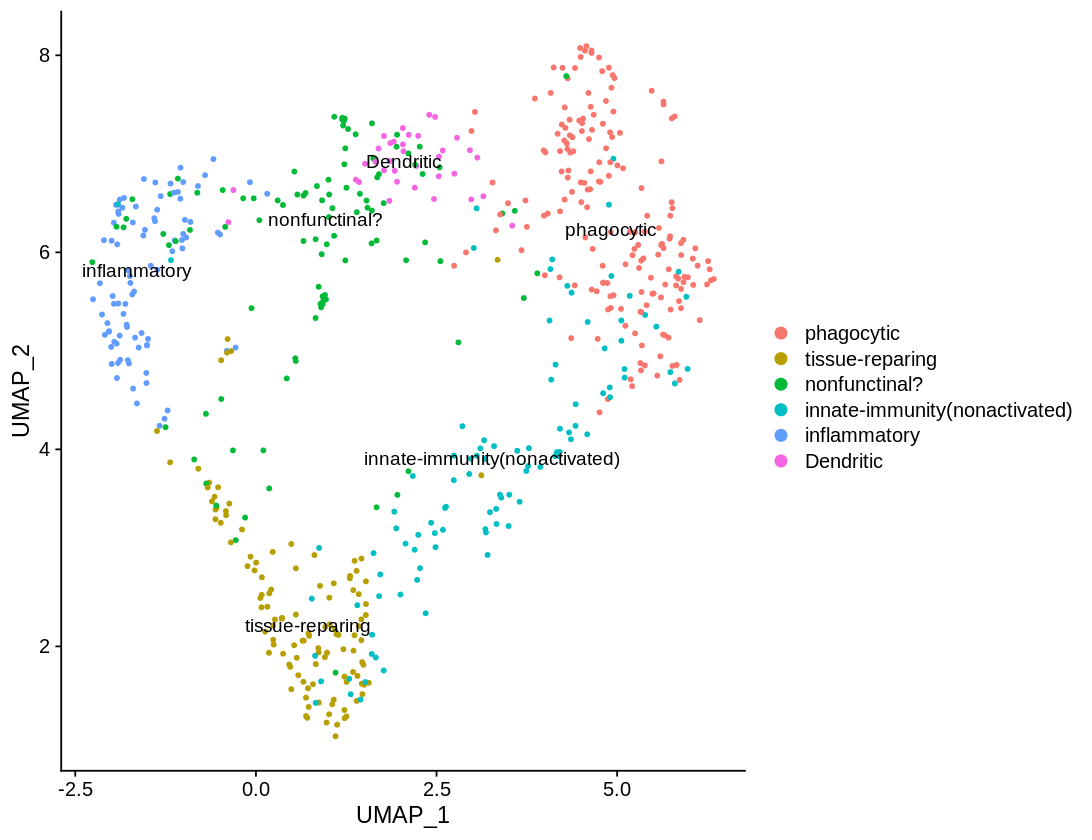

In [59]:
names(types) <- levels(macro2)
macro2 <- RenameIdents(macro2, types)
options(repr.plot.width=7*1.3, repr.plot.height=7)
DimPlot(macro2, reduction = "umap", label = TRUE)

In [60]:
cluster_count <- cluster_count_function(macro2, types)

In [61]:
cluster_count

,10N-total,11N-total,12N-total,14N-total,15N-total,16N-total,17N-total,6N-total,8N-total,9N-total
phagocytic,28,4,34,15,7,4,31,4,22,31
tissue-reparing,0,5,3,22,80,0,1,0,0,4
nonfunctinal?,4,4,6,7,27,5,12,12,7,18
innate-immunity(nonactivated),2,6,19,18,13,16,5,4,4,13
inflammatory,17,9,6,0,3,10,8,10,4,21
Dendritic,5,1,2,1,1,3,5,0,7,10


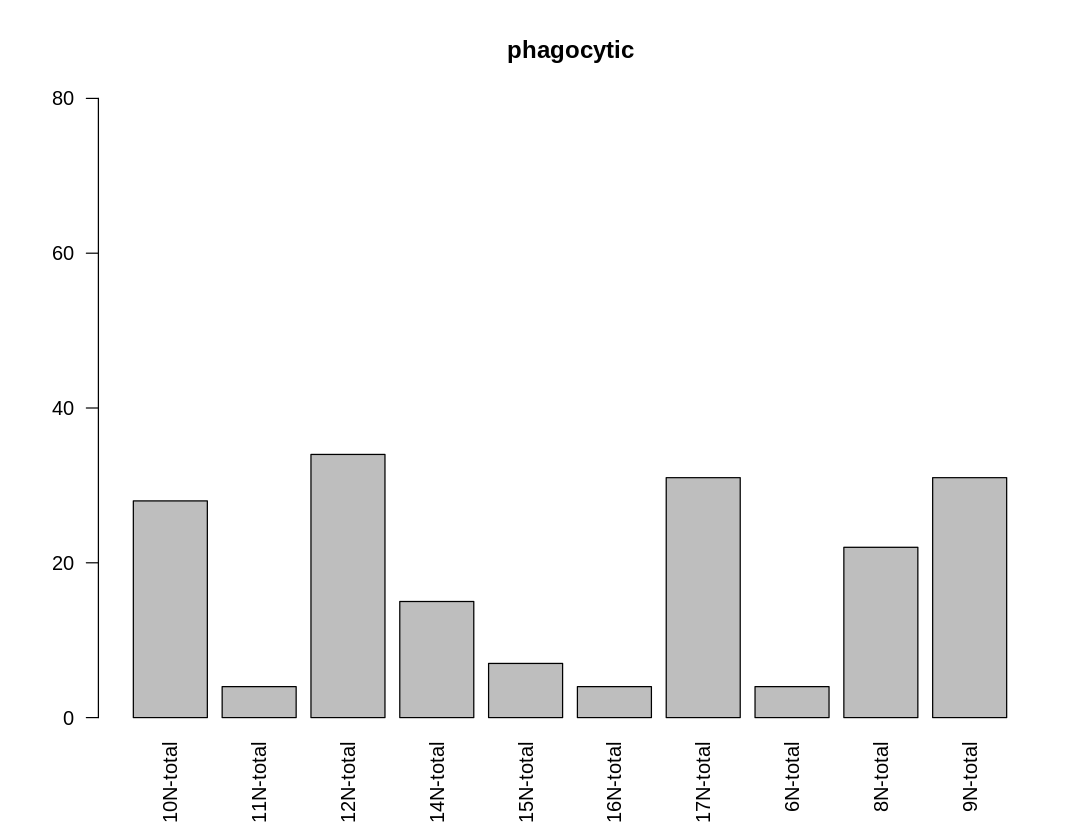

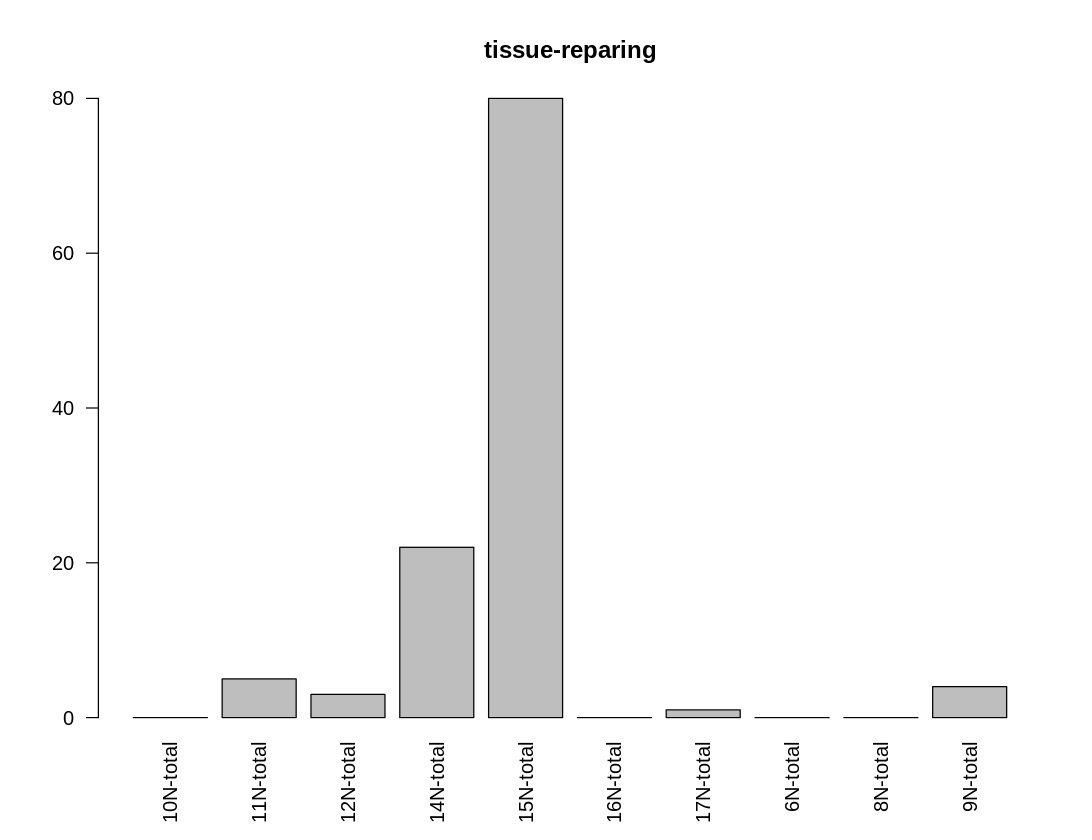

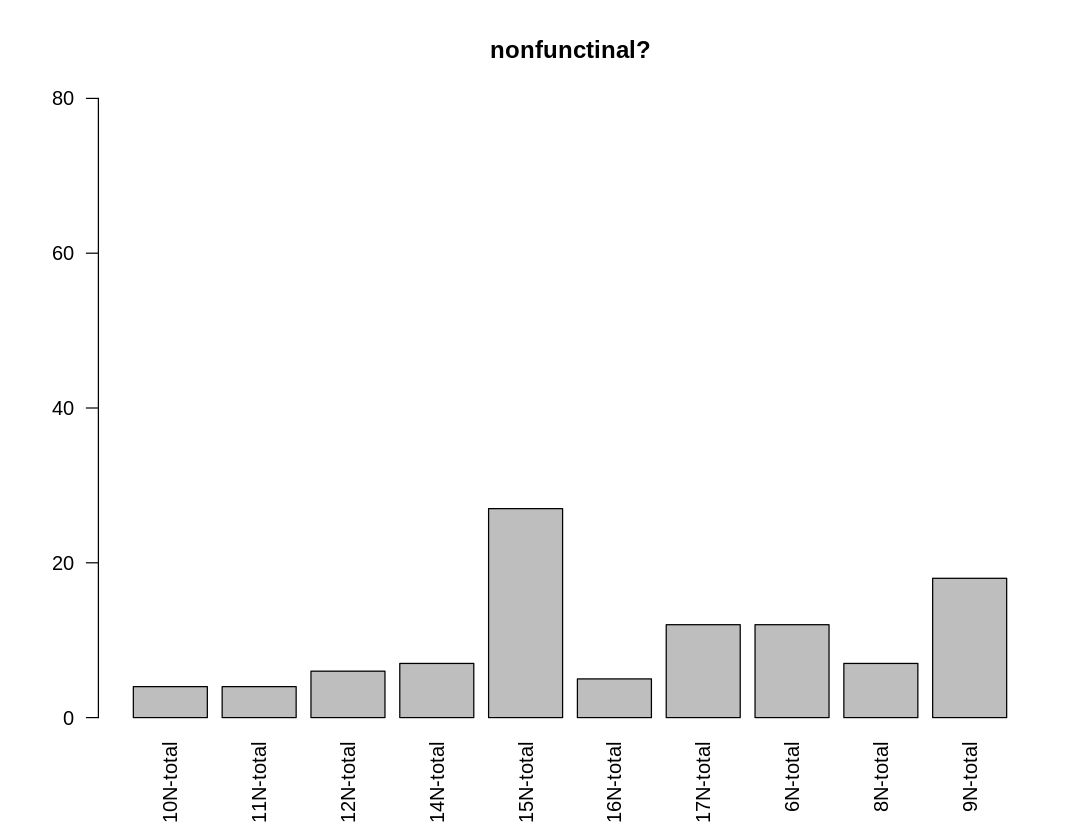

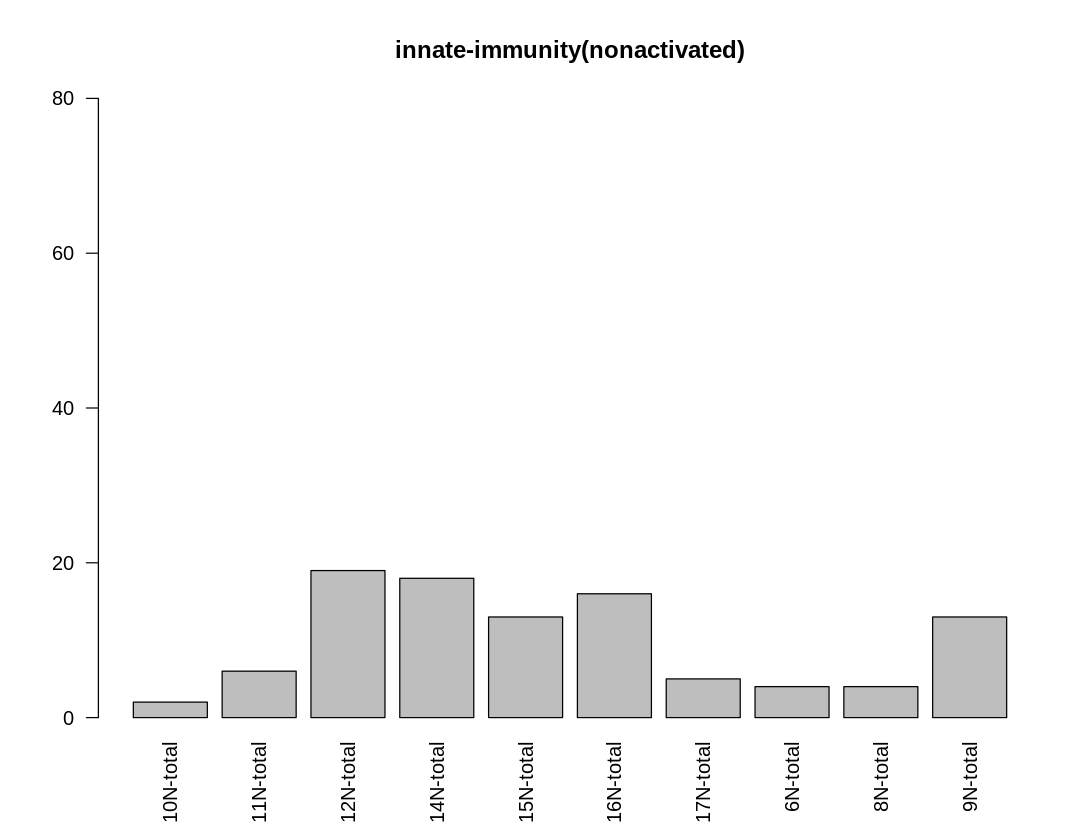

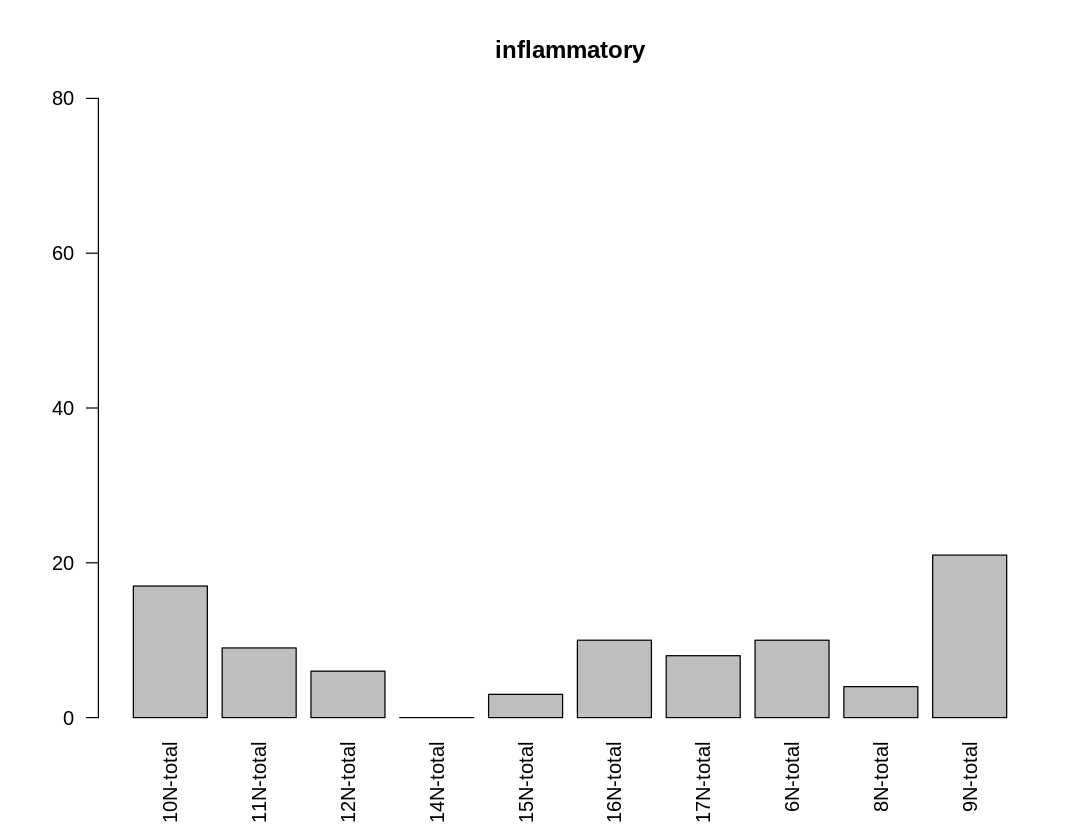

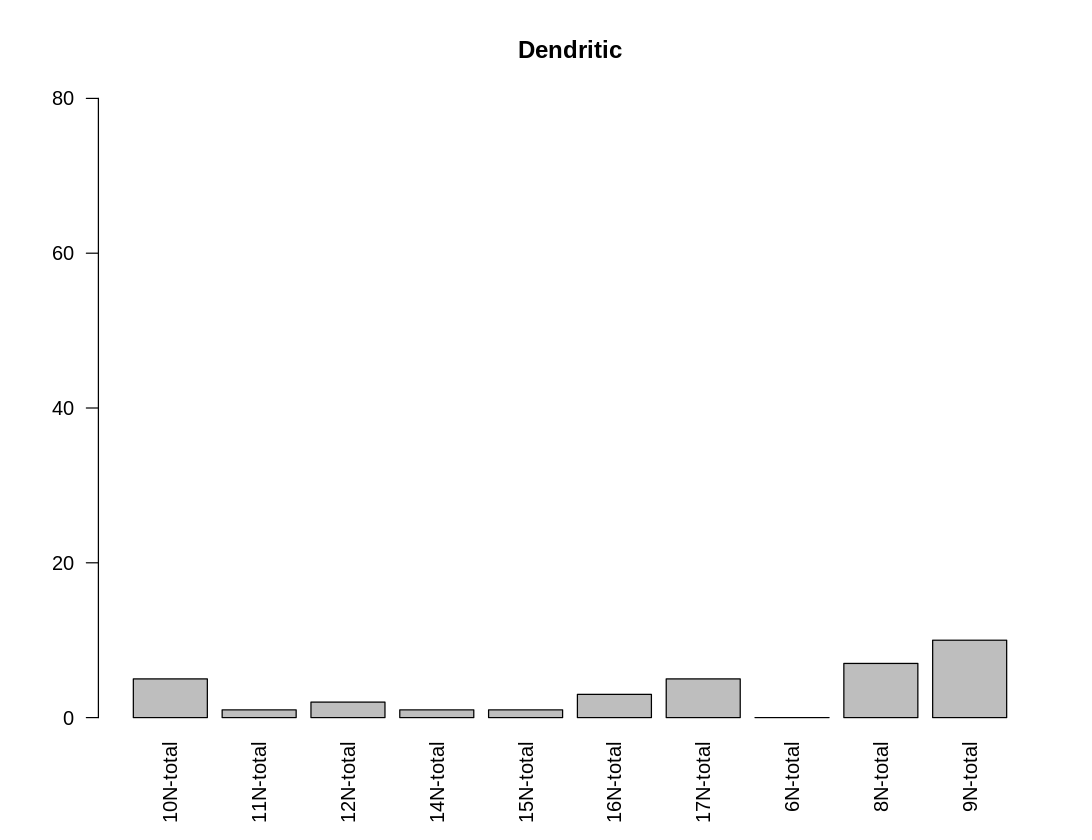

In [65]:
for (i in 1:dim(cluster_count)[1]){
    barplot(cluster_count[i,],las=2, main=rownames(cluster_count)[i],ylim=c(0,80))
}

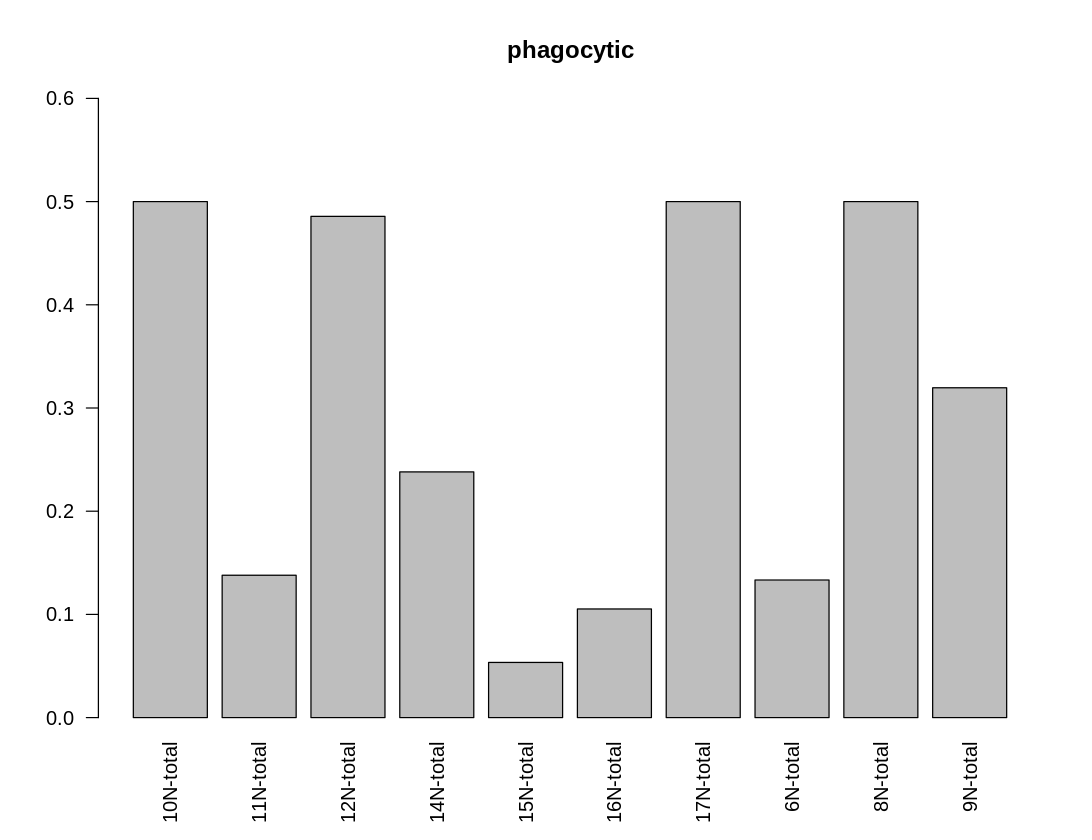

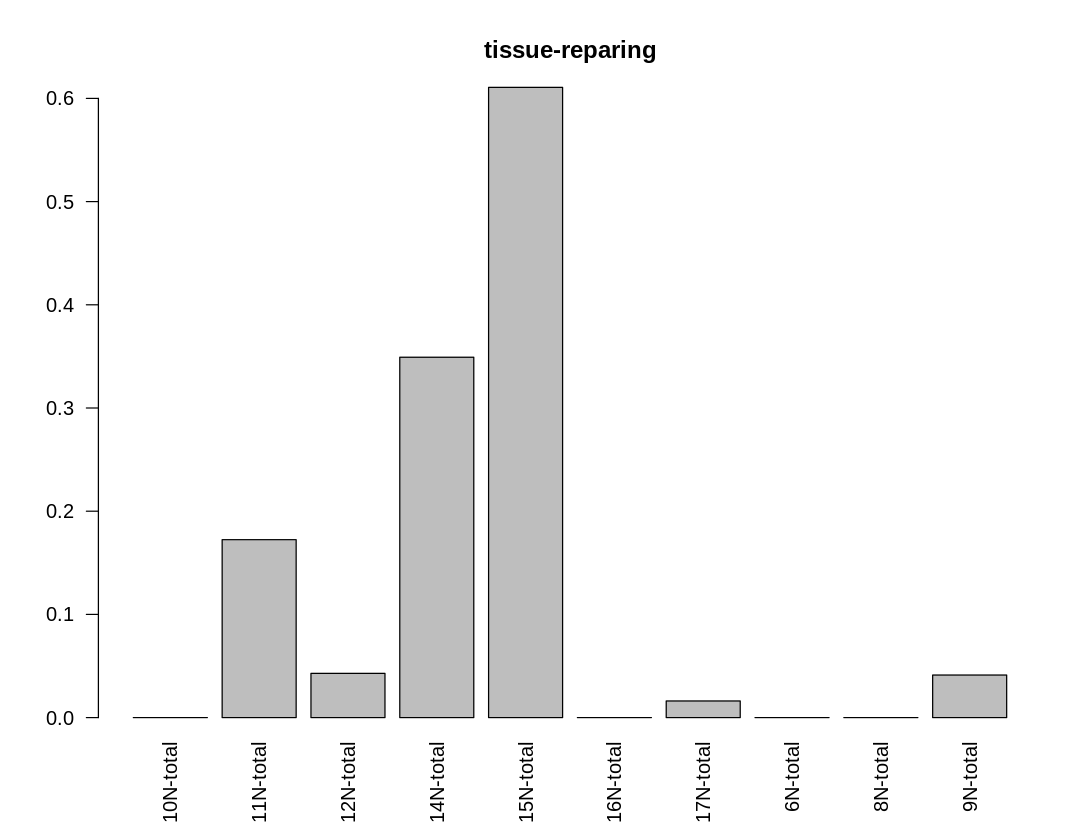

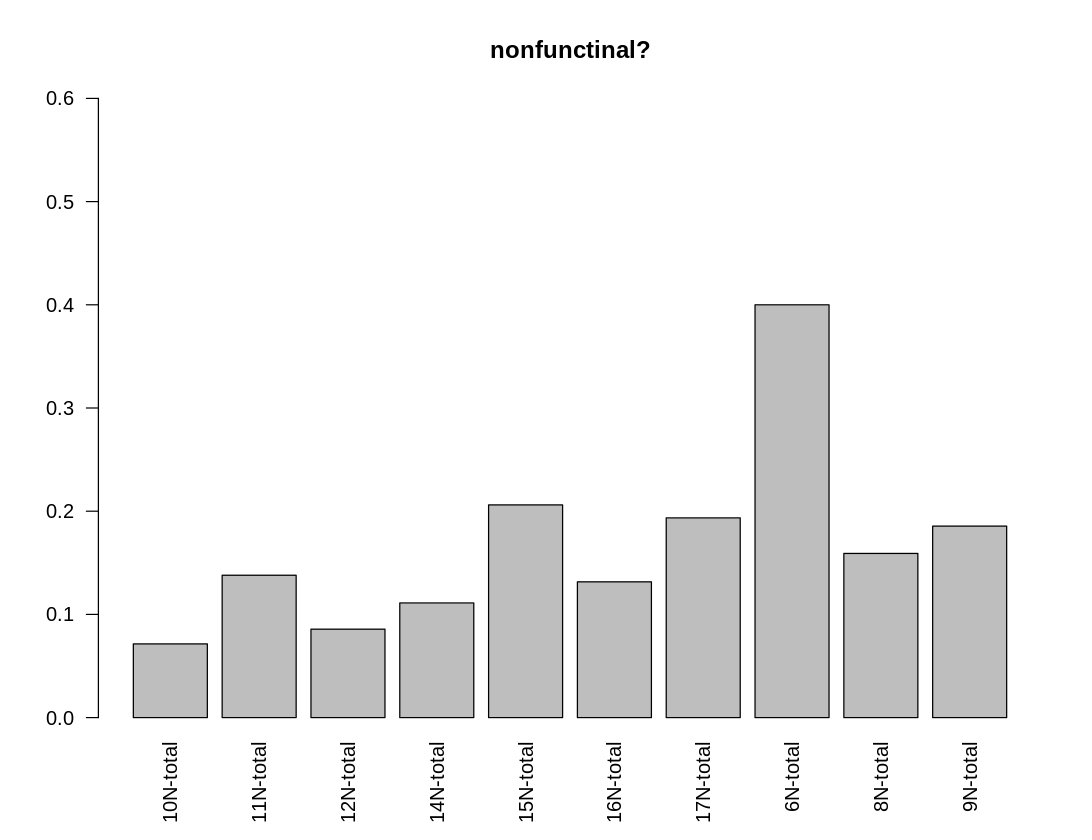

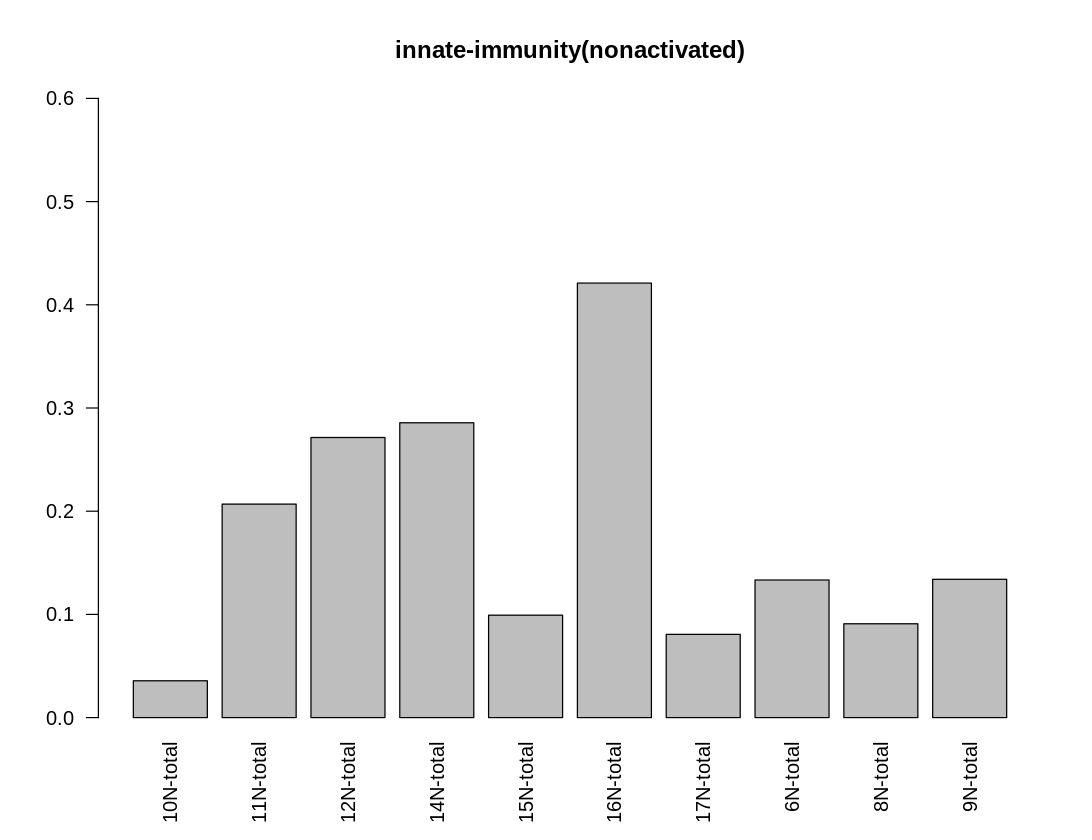

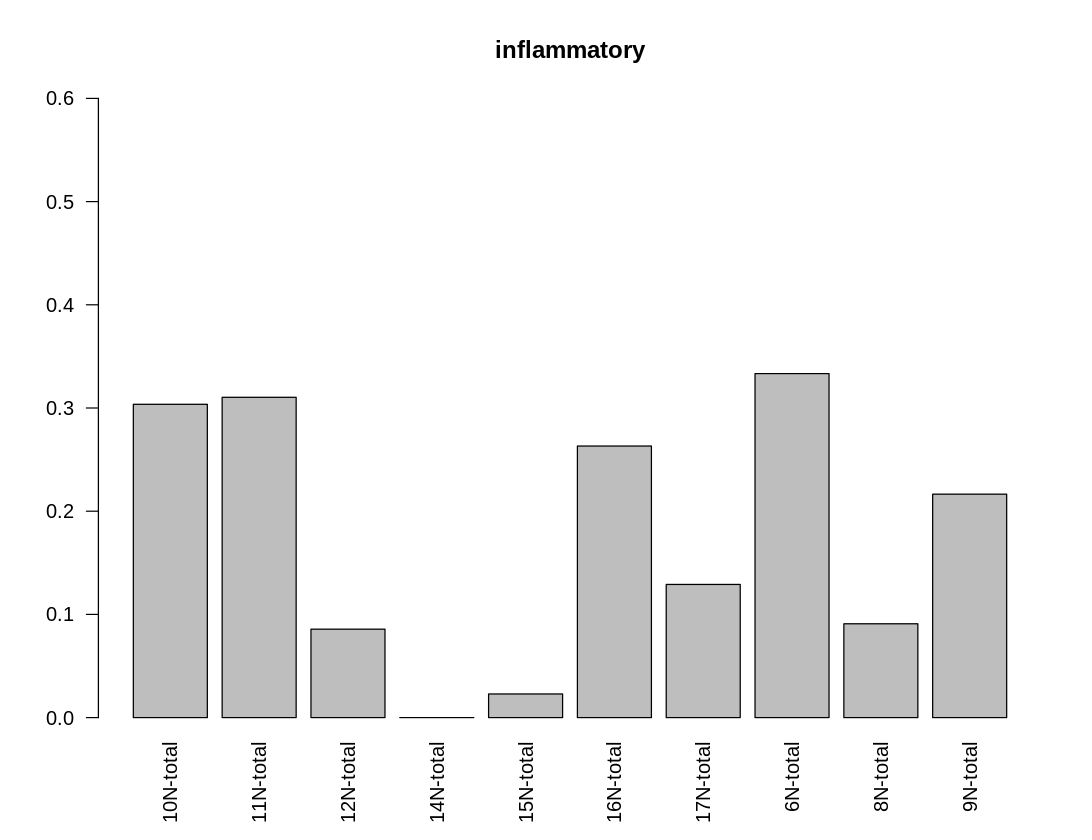

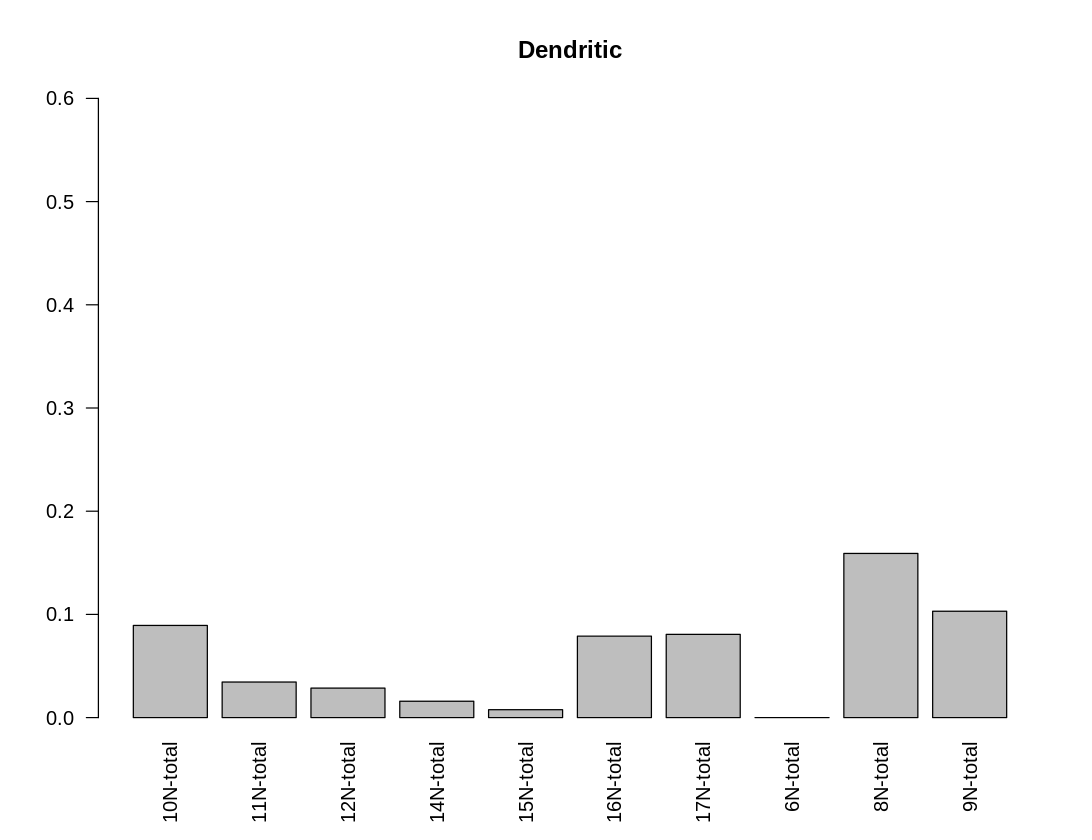

In [66]:
for (i in 1:dim(cluster_count)[1]){
    barplot(cluster_count[i,]/table(macrophages[[]]$orig.ident),las=2, main=rownames(cluster_count)[i],ylim=c(0,0.6))
}

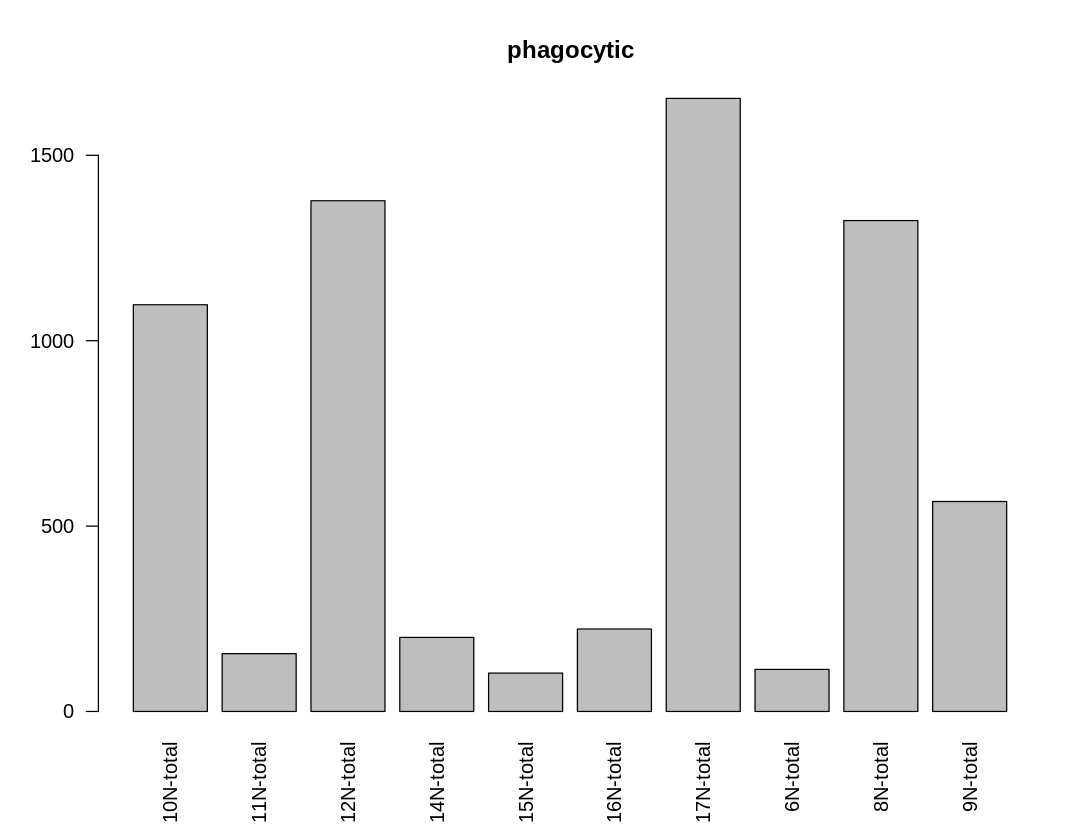

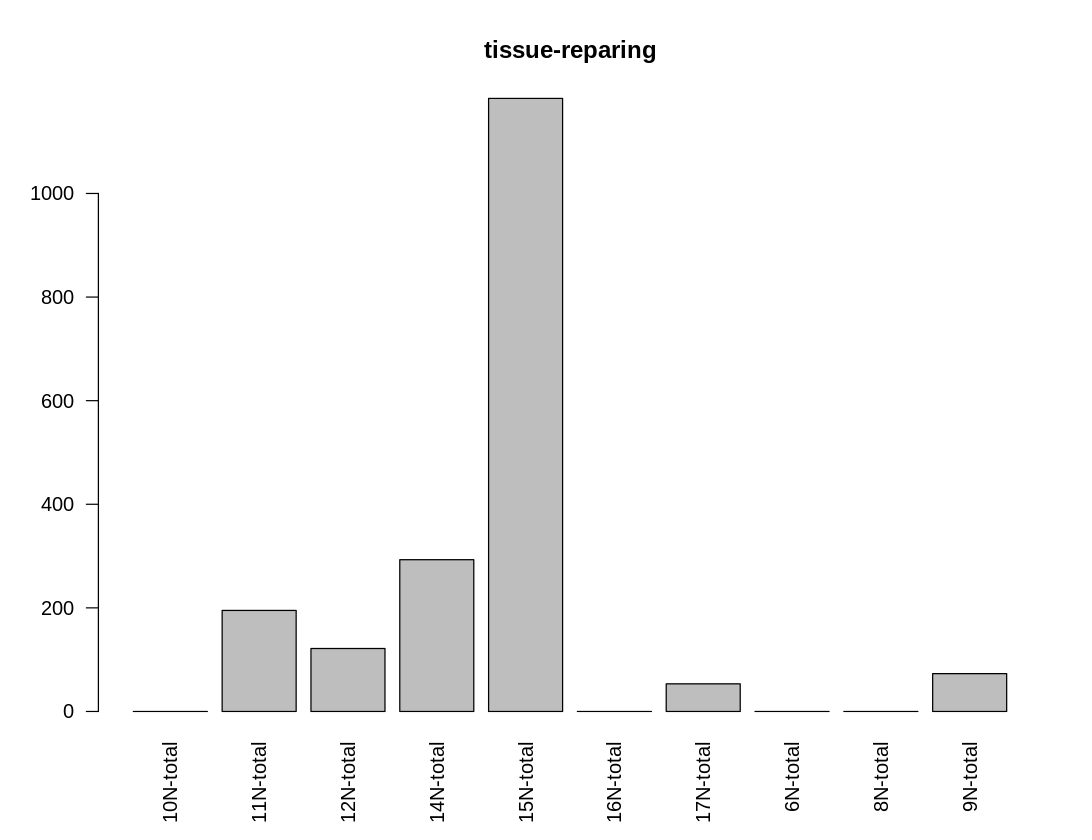

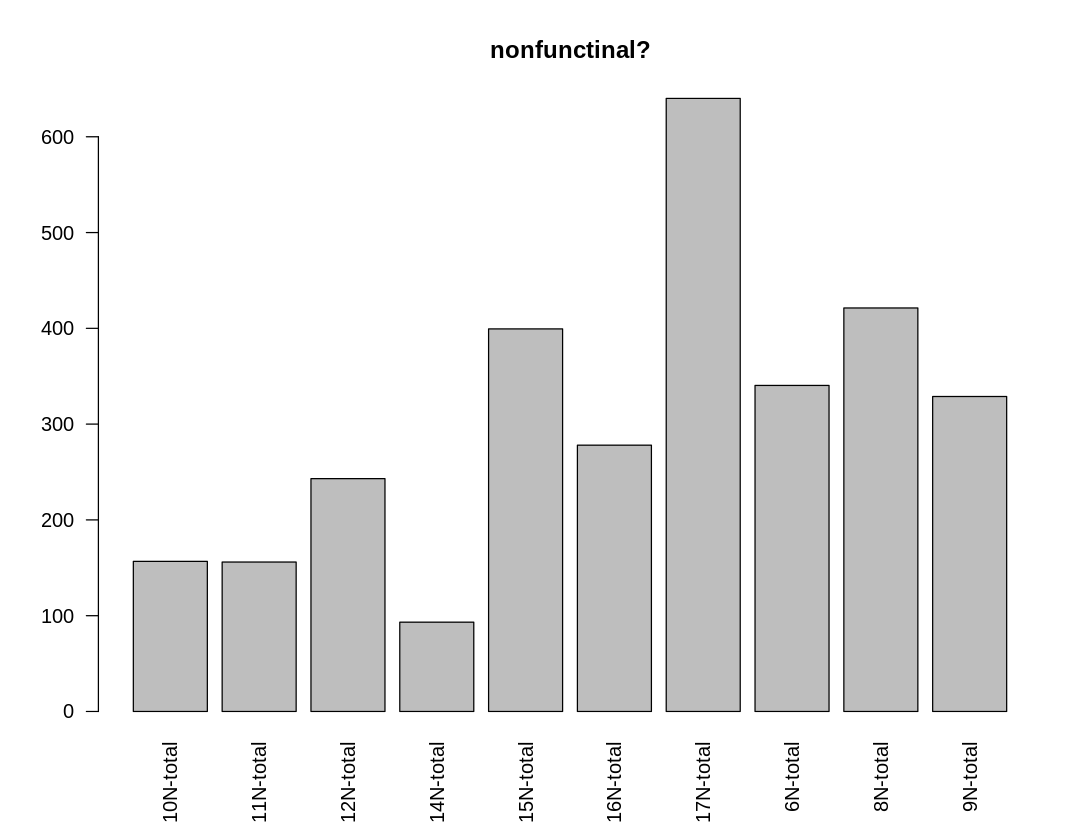

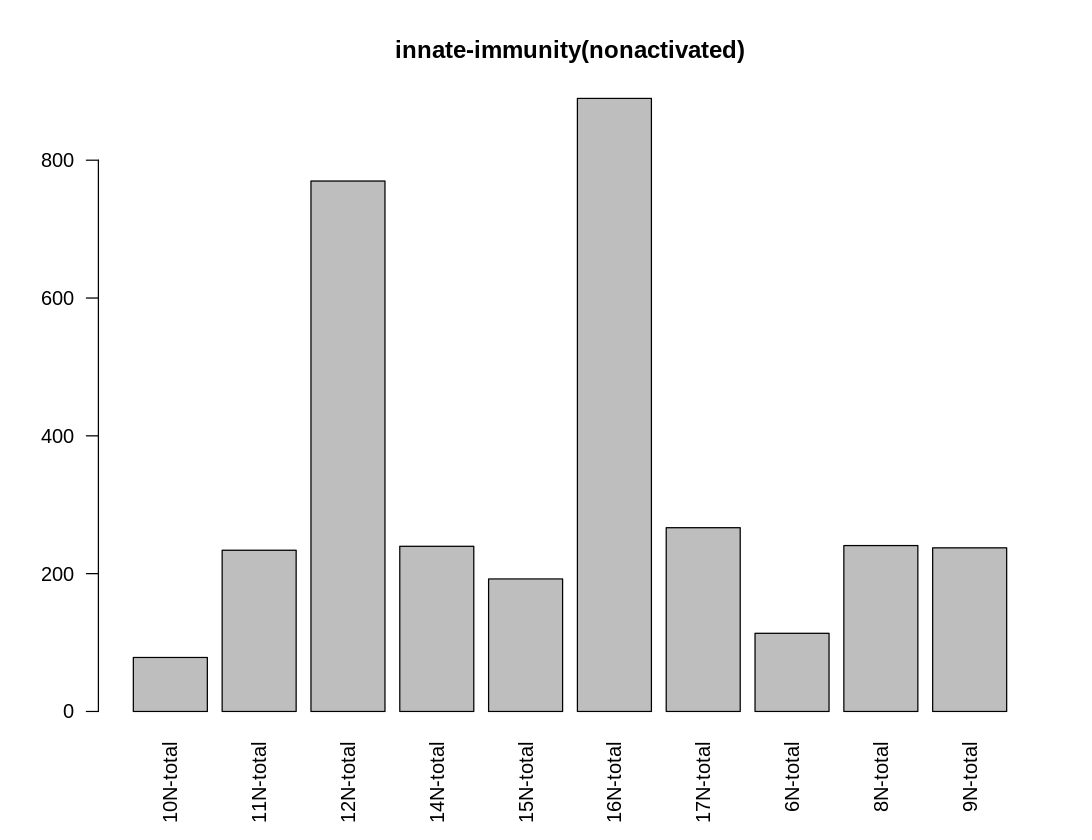

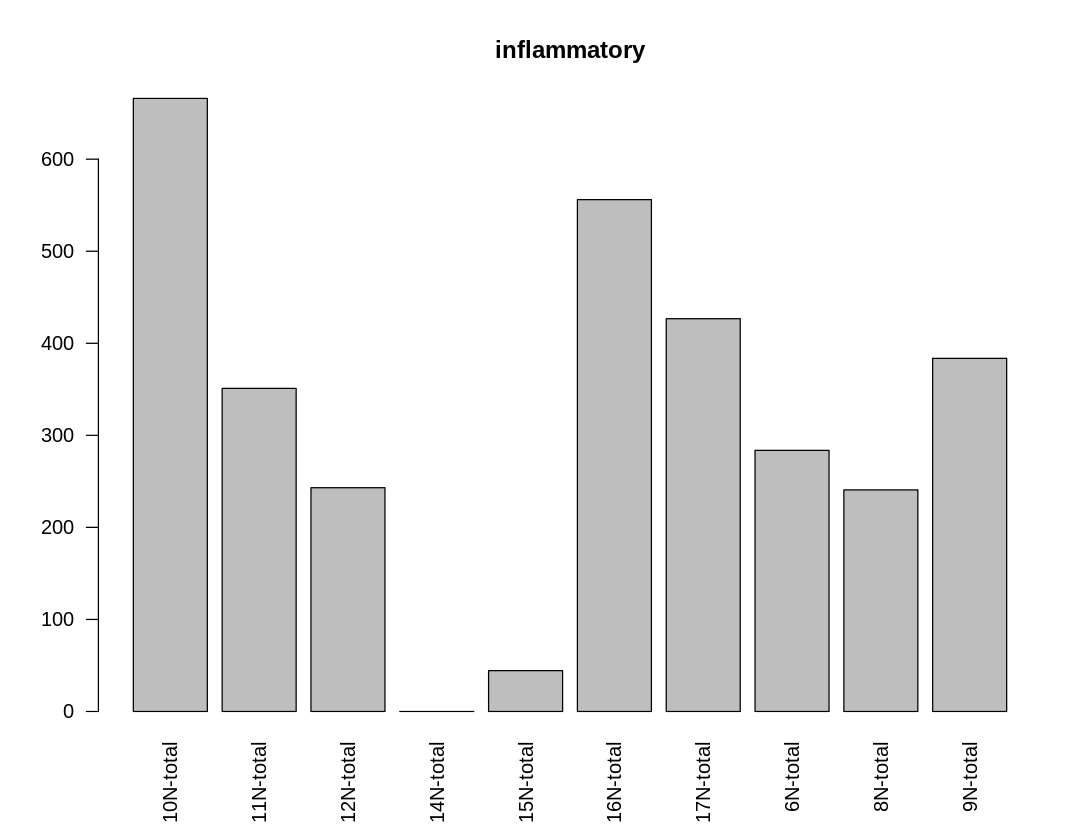

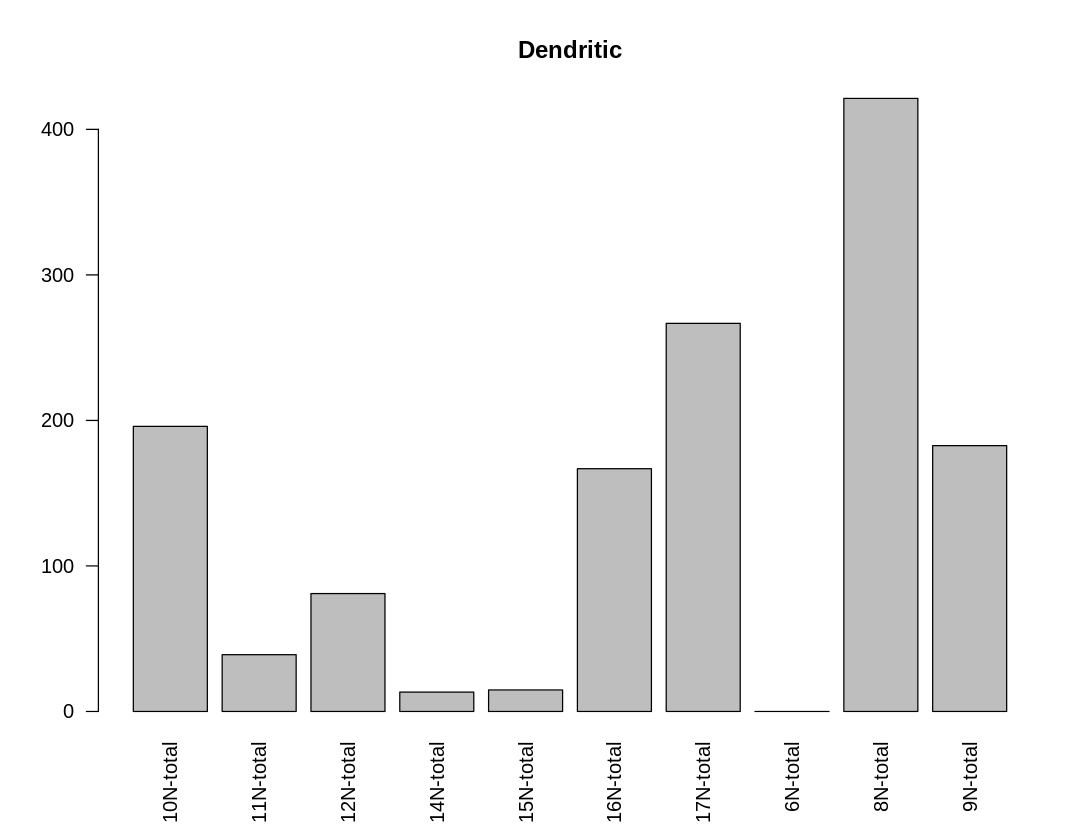

In [67]:
for (i in 1:dim(cluster_count)[1]){
    barplot(cluster_count[i,]/table(macrophages[[]]$orig.ident)*table(all[[]]$orig.ident),las=2, main=rownames(cluster_count)[i])
}